### We first start with a dummy ridge regressor that scored a RMSE of 167.1334 on the kaggle competition

In [4]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
airtrain = pd.get_dummies(airtrain,columns=['Gas'])


airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest = pd.get_dummies(airtest,columns=['Gas'])


X = airtrain.drop(['Value'],axis=1)
y = airtrain['Value']
model.fit(X, y)
predictions=model.predict(airtest)
predictions=pd.DataFrame(predictions)
predictions
predictions.to_csv('./predictions/1st_predictions.csv')




In [4]:
airtest = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtest.drop(airtest.columns[4:6],axis=1,inplace=True)
#drop airtest column id
airtest.drop(['id'],axis=1,inplace=True)
airtest.to_csv('./predictions/test.csv')

<AxesSubplot:>

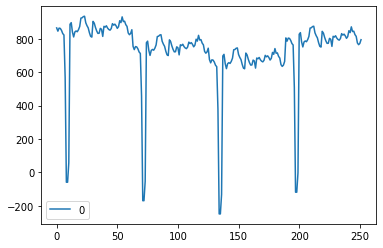

In [5]:
predictions.plot()

# Exploratory Data Analysis

In [76]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
# regression error metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

airtrain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T           1312 non-null   float64
 1   RH          1312 non-null   float64
 2   Gas         1312 non-null   object 
 3   Value       1312 non-null   float64
 4   Unnamed: 5  0 non-null      float64
 5   Unnamed: 6  0 non-null      float64
dtypes: float64(5), object(1)
memory usage: 71.8+ KB


### Looks like there are various types of Gases 

In [7]:
# show 5 random rows of dataframe 
# drop column index 5 and 6 dataframe
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

airtrain.sample(5)

T         RH  Gas        Value
Date                                              
2016-12-18  10.103125  56.785417   CO  1006.691667
2016-10-12  23.122917  54.558333   O3  1033.775000
2016-03-16   9.833333  64.069791  NO2  1021.750000
2016-09-25  25.569097  43.267708   O3   921.430556
2016-10-05  21.286458  53.091667   O3  1038.491667

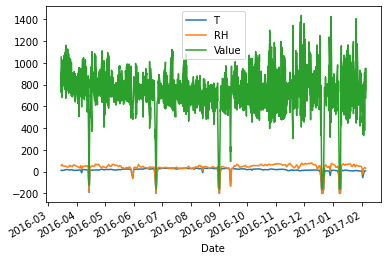

In [8]:
airtrain.plot()
plt.show()

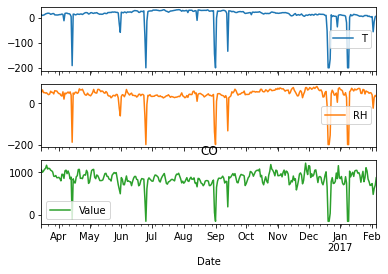

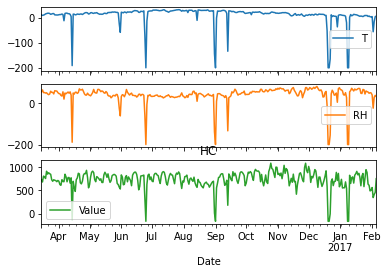

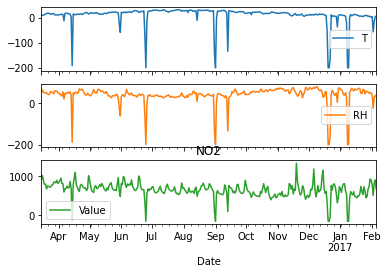

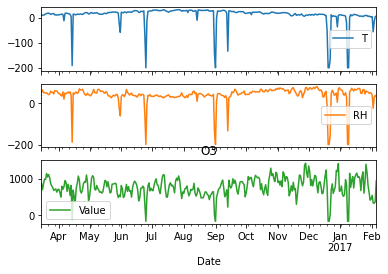

In [9]:
#plot a graph group by the Gas column with label as the Gas column
gases=airtrain.Gas.unique() #['CO' 'HC' 'NO2' 'O3']
# use a loop to filter out the gas column with the array gases

for gas in gases:
    airtrain[airtrain.Gas==gas].plot(subplots=True)
    #set title as gas at the top of each plot 
    plt.title(gas)
    plt.show()

### The attributes T, RH and Value are dropping below zero at certain points.  
There seems to be no missing values but 31 data points dropping below 0 which shouldn't be possible and it must be an error in the data.  



In [10]:
print(airtrain.info())
airtrain[airtrain['Value']<0].count()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1312 non-null   float64
 1   RH      1312 non-null   float64
 2   Gas     1312 non-null   object 
 3   Value   1312 non-null   float64
dtypes: float64(3), object(1)
memory usage: 51.2+ KB
None


T        31
RH       31
Gas      31
Value    31
dtype: int64

### When T or RH is -200 , Value will always be -200  
This shouldn't happen in the real world as having -200 temperature and -200 RH will mean the end of the world  
I assume that there was some maintenance work to the machinery when collecting data . Which explains why its consistenty having the exact value.  
I will also change the values to -160 when T or RH is -200 in the test data set.

In [11]:
#np.logical_or in list comprehension of airtrain
print('Times when T or RH is -200 and Value is not -160',airtrain[((airtrain['T']==-200) | (airtrain["RH"] ==-200)) & (airtrain['Value']!=-160)].count())

#This just shows that when T or RH is -200 and Value is always -160

Times when T or RH is -200 and Value is not -160 T        0
RH       0
Gas      0
Value    0
dtype: int64


### Looks like the dataset is also normally distributed for each of its attributes

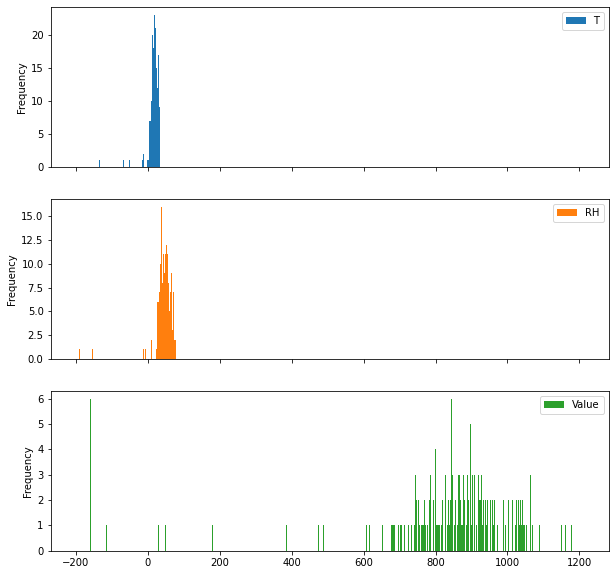

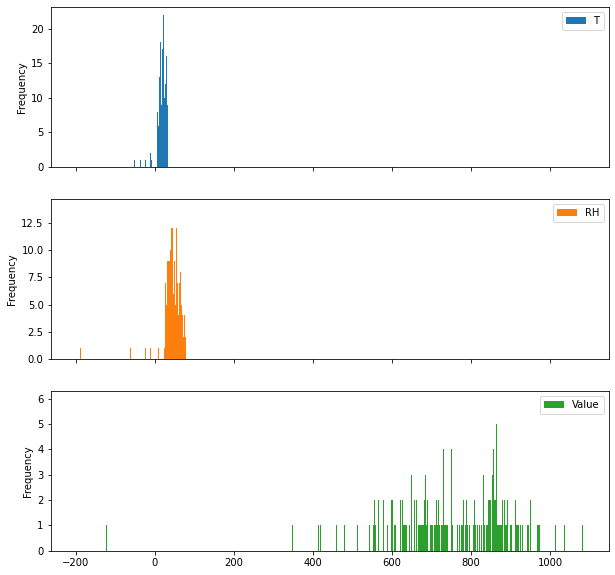

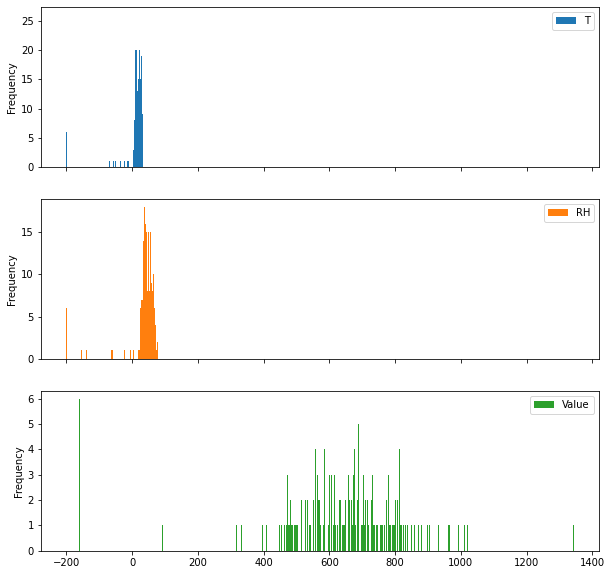

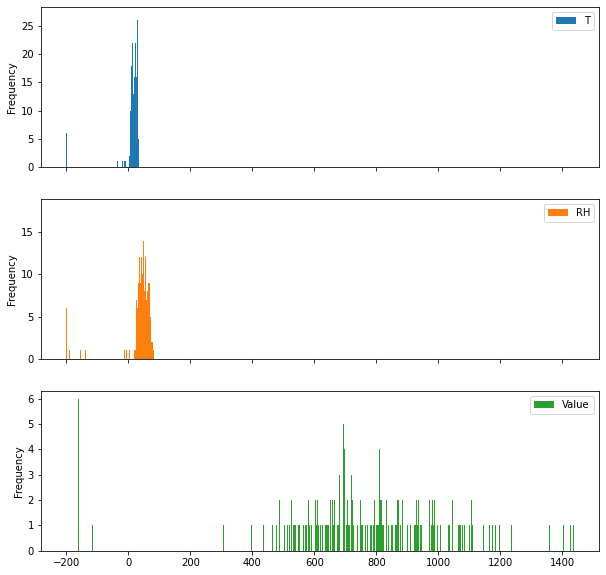

In [12]:
# plot a graph group by the Gas column with label as the Gas column
airtrain.groupby('Gas').plot(kind='hist',subplots=True,figsize=(10,10),bins = 1000)
plt.show()

### Stationarity test
[stationarity test]https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/  

We will perform both augmented dickey fuller(Adfuller) test and a Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test  
to find out whether the dataset has a unit root

In [13]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
result3 = adfuller(airtrain.Value)
print('number of observations:',result3[3],'\nAir Dataset Value attribute p-value: %f' % result3[1])

number of observations: 1288 
Air Dataset Value attribute p-value: 0.000039


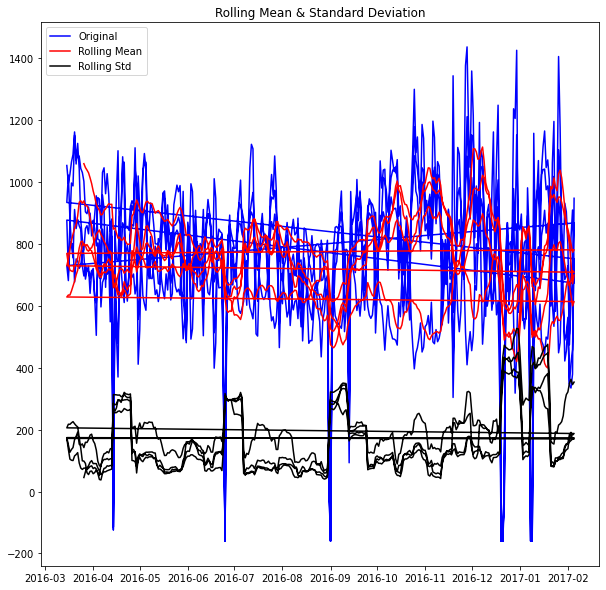

Results of Dickey-Fuller Test:
Test Statistic                   -4.874493
p-value                           0.000039
#Lags Used                       23.000000
Number of Observations Used    1288.000000
Critical Value (1%)              -3.435437
Critical Value (5%)              -2.863787
Critical Value (10%)             -2.567966
dtype: float64
Strong evidence to reject the null hypothesis, the series is stationary


In [14]:
#test for stationarity in airtrain dataframe
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=[10,10])
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # check if the p-value is less than 0.05, if yes, then we can reject the null hypothesis that the data is stationary
    if dftest[1] < 0.05:
        print('Strong evidence to reject the null hypothesis, the series is stationary')
    else:
        print('Weak evidence to reject the null hypothesis, the series is non-stationary')
        
    plt.show()

test_stationarity(airtrain.Value)

In [15]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
kpss_test(airtrain.Value,regression='c')

KPSS Statistic: 1.2249555213186396
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Differencing will be done as recommended by Statsmodels.org  
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html  

Case 1: Both tests conclude that the series is not stationary - The series is not stationary  

Case 2: Both tests conclude that the series is stationary - The series is stationary  

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.  

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.



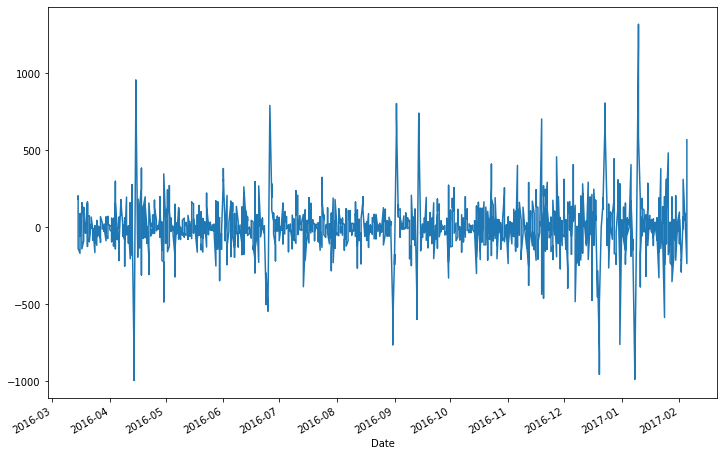

In [16]:
airtrain["Value_diff"] = airtrain["Value"] - airtrain["Value"].shift(1)
airtrain["Value_diff"].dropna().plot(figsize=(12, 8))
plt.show()

In [17]:

airtrain['Value_diff']=airtrain['Value_diff'].fillna(airtrain['Value_diff'].mean())

### Great looks like it is stationary now

In [18]:
kpss_test(airtrain["Value_diff"], regression='c')

KPSS Statistic: 0.15740610515715728
p-value: 0.1
num lags: 187
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


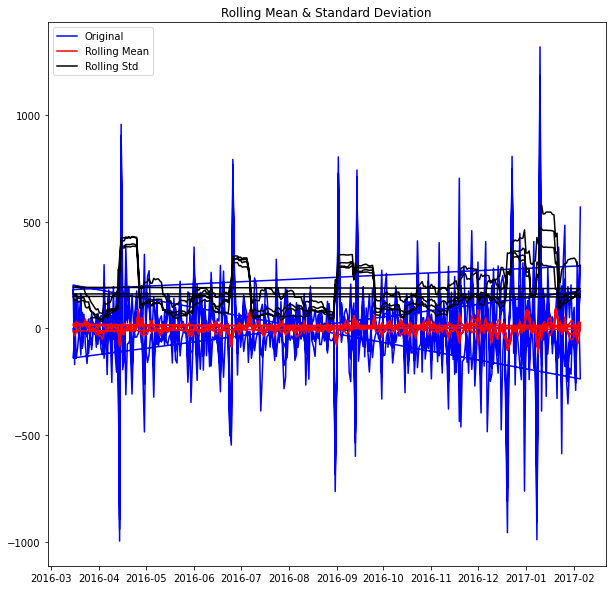

Results of Dickey-Fuller Test:
Test Statistic                -1.150443e+01
p-value                        4.411004e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.288000e+03
Critical Value (1%)           -3.435437e+00
Critical Value (5%)           -2.863787e+00
Critical Value (10%)          -2.567966e+00
dtype: float64
Strong evidence to reject the null hypothesis, the series is stationary


In [19]:
test_stationarity(airtrain["Value_diff"])

# Feature Engineering
## Firstly we pivot the dataset for a better overview 

In [20]:
# pivot table
data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
temp = pd.DataFrame(data['T'].groupby(['Date']).mean())
rh = pd.DataFrame(data['RH'].groupby(['Date']).mean())
pivot = pd.pivot(data, columns = 'Gas', values = 'Value')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
df

T         RH     CO_Value    HC_Value    NO2_Value  \
Date                                                                     
2016-03-15  12.020833  54.883334  1053.200000  729.800000   933.800000   
2016-03-16   9.833333  64.069791   995.250000  681.441667  1021.750000   
2016-03-17  11.292708  51.107292  1025.250000  806.583333   881.375000   
2016-03-18  12.866319  51.530903  1064.444444  794.258333   794.527778   
2016-03-19  16.016667  48.843750  1088.741667  755.083333   800.883333   
...               ...        ...          ...         ...          ...   
2017-02-01   5.267708  39.614930   729.422222  562.650000   797.647222   
2017-02-02 -55.515972 -24.010417   474.291667  347.480556   508.180556   
2017-02-03 -14.272917  28.563542   615.700000  414.475000   819.733333   
2017-02-04   4.848611  37.832986   691.713889  458.947222   909.375000   
2017-02-05   7.273958  31.809375   867.600000  751.833333   673.741667   

              O3_Value  
Date                    
2016-03-15  876.833333  
2016-03-16  708.025000  
2016-03-17  867.375000  
2016-03-18  996.625000  
2016-03-19  987.341667  
...                ...  
2017-02-01  553.180556  
2017-02-02  343.500000  
2017-02-03  334.458333  
2017-02-04  379.513889  
2017-02-05  947.333333  

[328 rows x 6 columns]

### Correlation test using pivoted data from this I can infer that there is correlation between T,RH and the gases and different Gases are more correlated T than RH and vice versa. There was also correlation between the various Gases Values but unfortunately the test.csv data does not provide them .

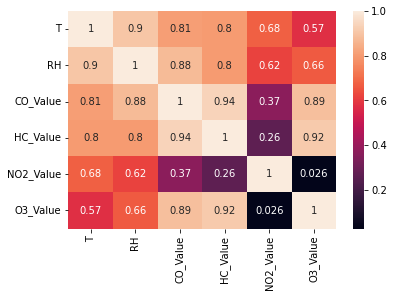

In [21]:
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Further Analysis using Feature Engineered Data
## ACF AND PACF
### It is important to make sure data is stationary before plotting Auto Correlation Function (ACF)  
Help us uncover hidden patterns in our data and help us select the correct forecasting methods.  

KEY THINGS ACF CAN TELL US:
- we can also tell stationarity based on ACF
- How many days we should lag for best prediction results
- Hidden patterns 
- Seasonality
- Randomness
- Selecting Time Series Models


### The ACF function will be used to determine the order of MA(q) process. 
### The PACF function will be used to determine the order of AR(p) process. 


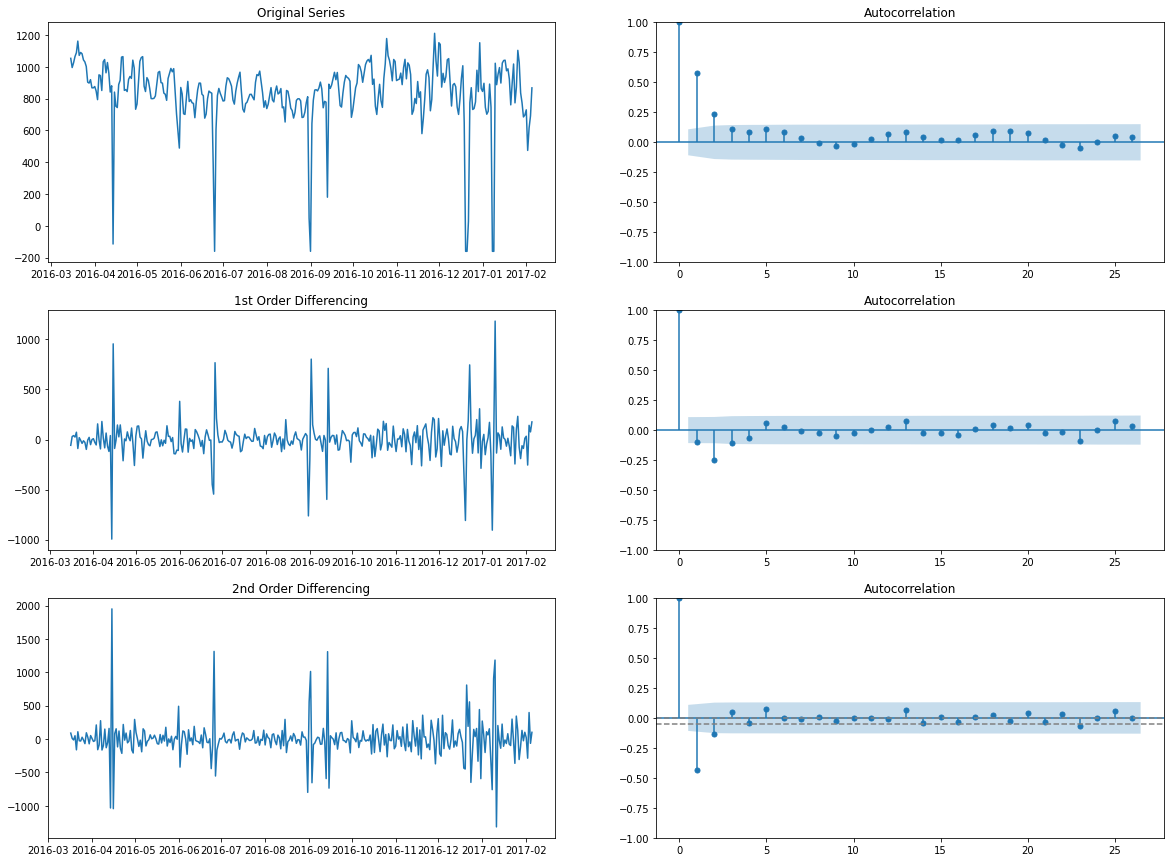

In [22]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(20,15)})

# Import data

# Original Series
fig, axes = plt.subplots(nrows=3, ncols=2)
axes[0, 0].plot(df.CO_Value); axes[0, 0].set_title('Original Series')
plot_acf(df.CO_Value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.CO_Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.CO_Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.CO_Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.CO_Value.diff().diff().dropna(), ax=axes[2, 1])


plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airtrain.Value)),linestyle='--',color='gray')
plt.show()

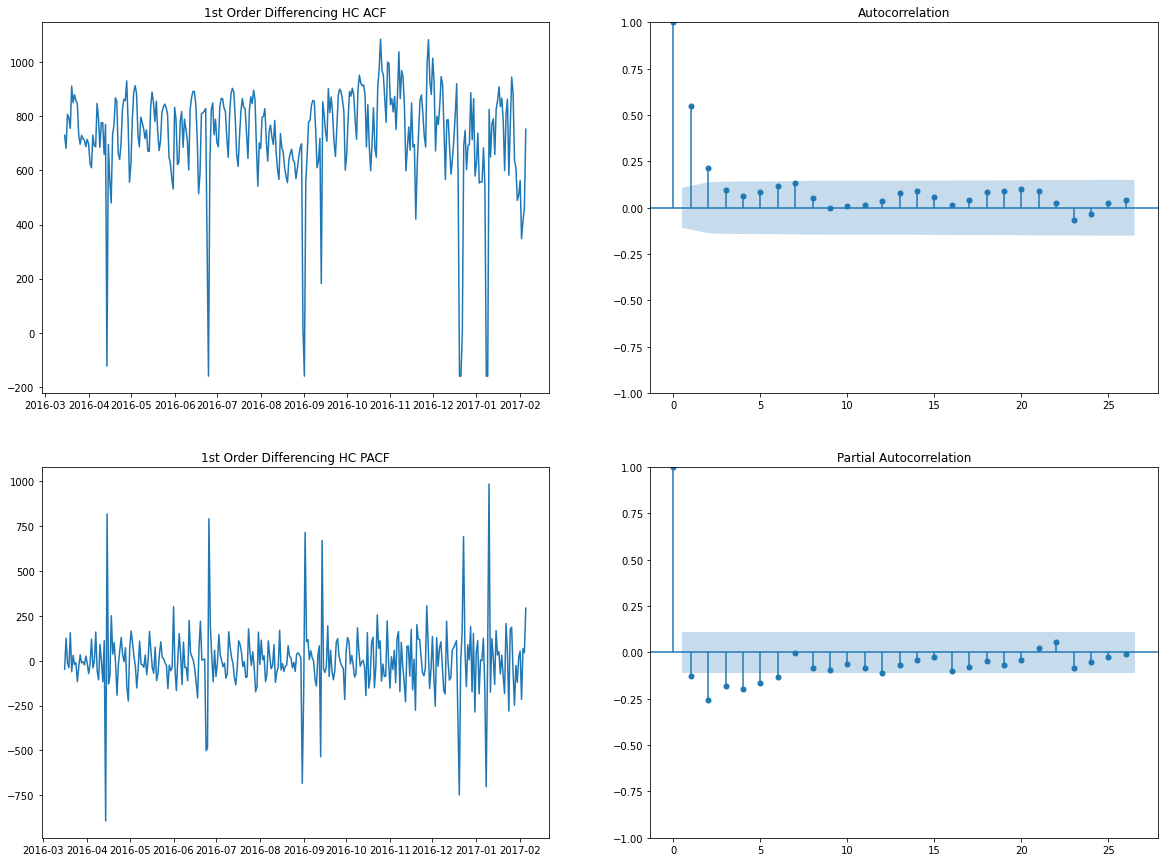

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# Original Series for HC
axes[0, 0].plot(df.HC_Value); axes[0, 0].set_title('1st Order Differencing HC ACF')
plot_acf(df.HC_Value.dropna(), ax=axes[0, 1]);

# 1st Differencing for HC
axes[1, 0].plot(df.HC_Value.diff()); axes[1, 0].set_title('1st Order Differencing HC PACF')
plot_pacf(df.HC_Value.diff().dropna(), ax=axes[1, 1],method ='ywm');



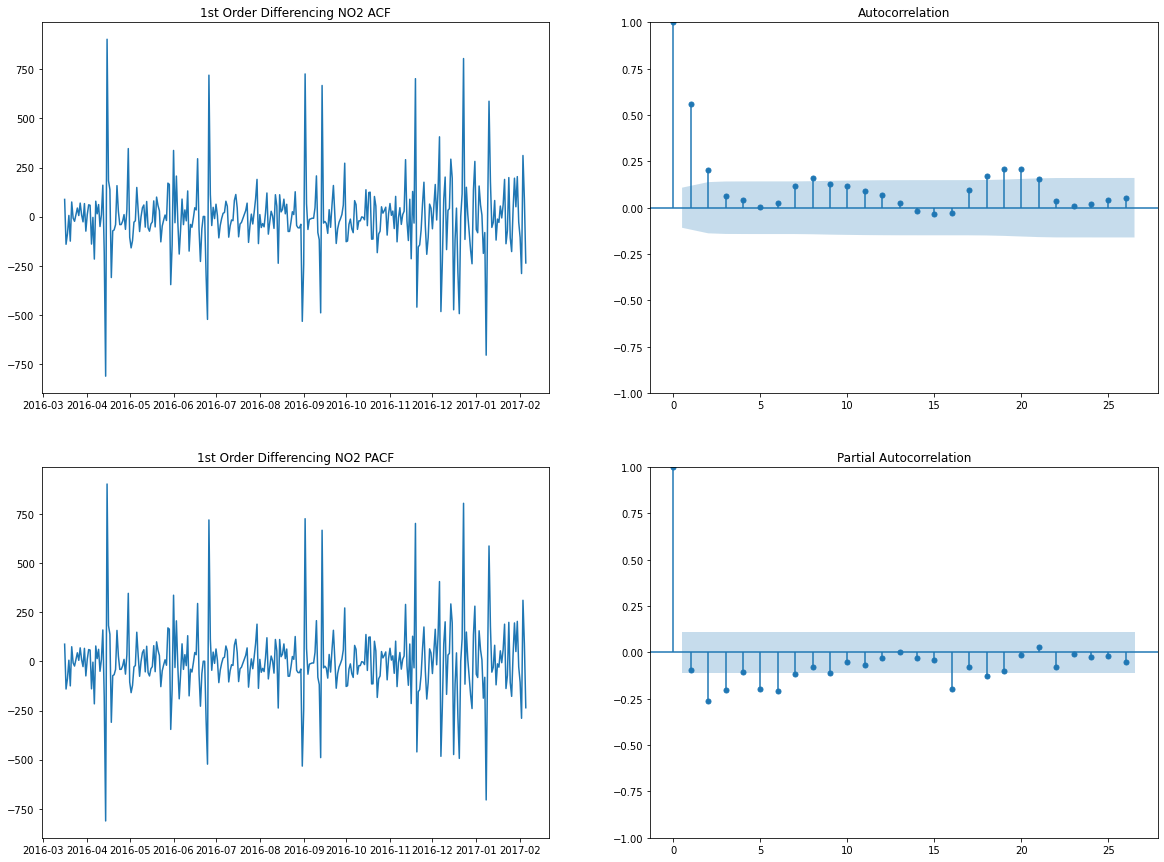

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# Original Series for NO2
axes[0, 0].plot(df.NO2_Value.diff()); axes[0, 0].set_title('1st Order Differencing NO2 ACF')
plot_acf(df.NO2_Value.dropna(), ax=axes[0, 1]);

# 1st Differencing for NO2
axes[1, 0].plot(df.NO2_Value.diff()); axes[1, 0].set_title('1st Order Differencing NO2 PACF')
plot_pacf(df.NO2_Value.diff().dropna(), ax=axes[1, 1],method ='ywm');



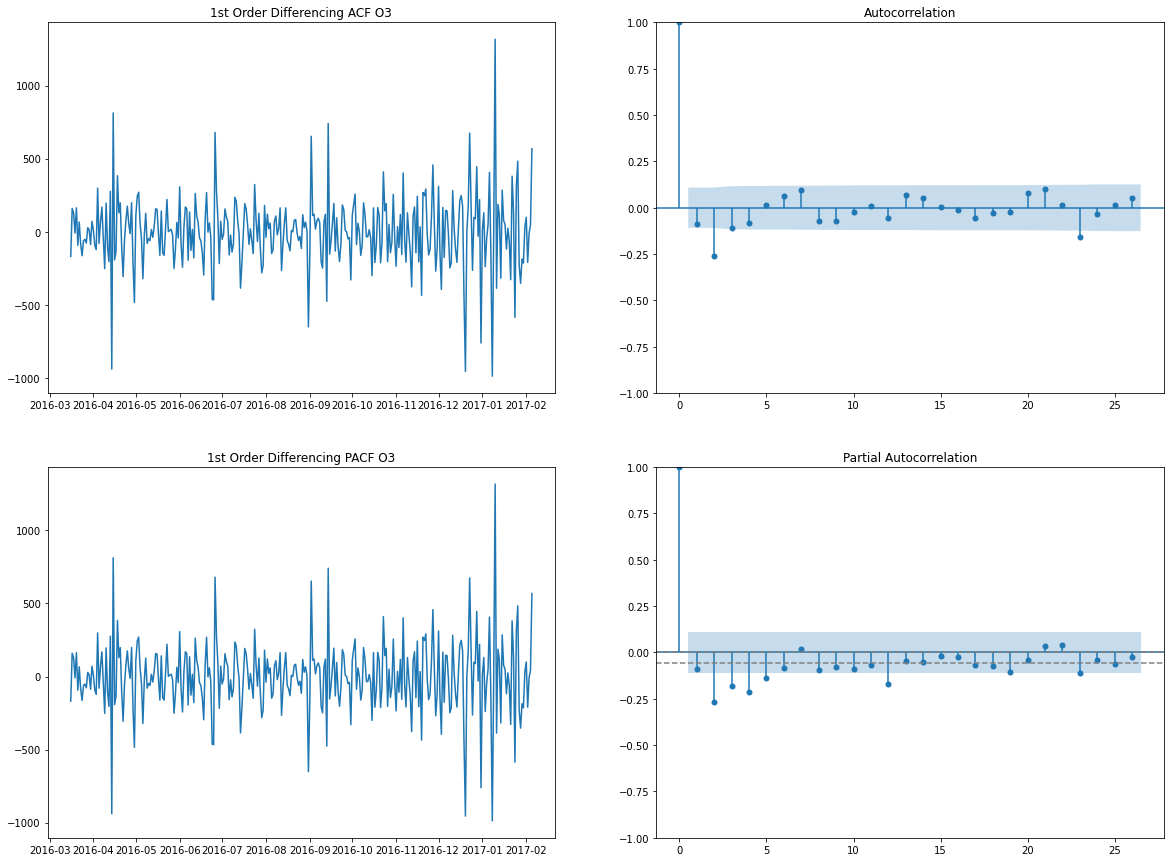

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
# Original Series for O3
axes[0, 0].plot(df.O3_Value.diff()); axes[0, 0].set_title('1st Order Differencing ACF O3')
plot_acf(df.O3_Value.diff().dropna(), ax=axes[0, 1])

# 1st Differencing for O3
axes[1, 0].plot(df.O3_Value.diff()); axes[1, 0].set_title('1st Order Differencing PACF O3')
plot_pacf(df.O3_Value.diff().dropna(), ax=axes[1, 1],method ='ywm')

plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airtrain.Value)),linestyle='--',color='gray')
# plt.title('Partial Auto Correlation Function')
plt.show()

In [26]:
from pmdarima.arima.utils import ndiffs
y=airtrain.Value
## Adf Test
print("adf-ndiffs",ndiffs(y, test='adf'))

# KPSS test
print("kpss-ndiffs",ndiffs(y, test='kpss'))  

# PP test:
print("PP-ndiffs",ndiffs(y, test='pp') )

adf-ndiffs 0
kpss-ndiffs 1
PP-ndiffs 0


![Table to determine model](./ACF_PACF.png)
#### Based on the results above , I recognise that there is strong cut-offs or significant acf/pacf vals at 1 or 2 lag  
- p or AR could be 1 or 2 
- q or MA could be 1 or 2 
- Both ACF and PACF seems to be tailing off and based on table so we shall predict with a ARMA model
- There is also a subtle peak in correlation roughly every 10 lags / months 
- I used a difference of 1 so d would be 1.


### Seasonal decomposition

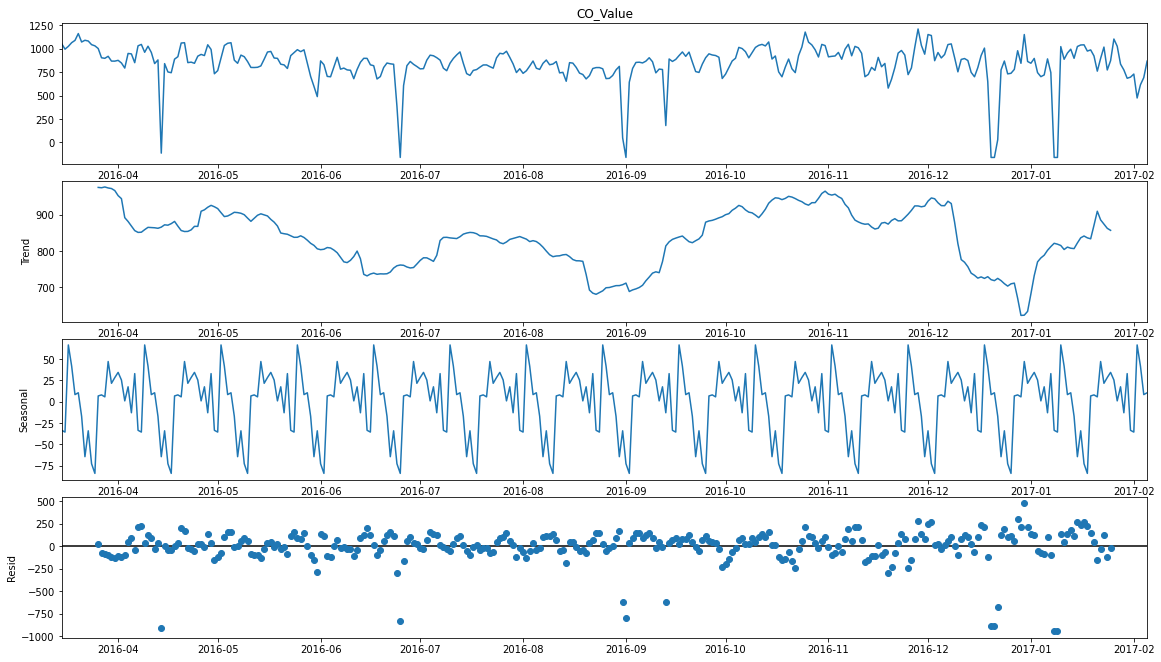

In [27]:
#Timeseries decomposition on airtrain data
from statsmodels.tsa.seasonal import seasonal_decompose
# import data
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)

temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value')
analyse = temp.join([rh, pivot])
analyse.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)

# only take 2016 to 2017 feb
time_decompose=analyse.loc['2016' : '2017-02']
analyse.CO_Value.sort_index()
decompose_result_mult = seasonal_decompose(time_decompose.CO_Value, model="additive",period = int(len(time_decompose.CO_Value)/14))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()

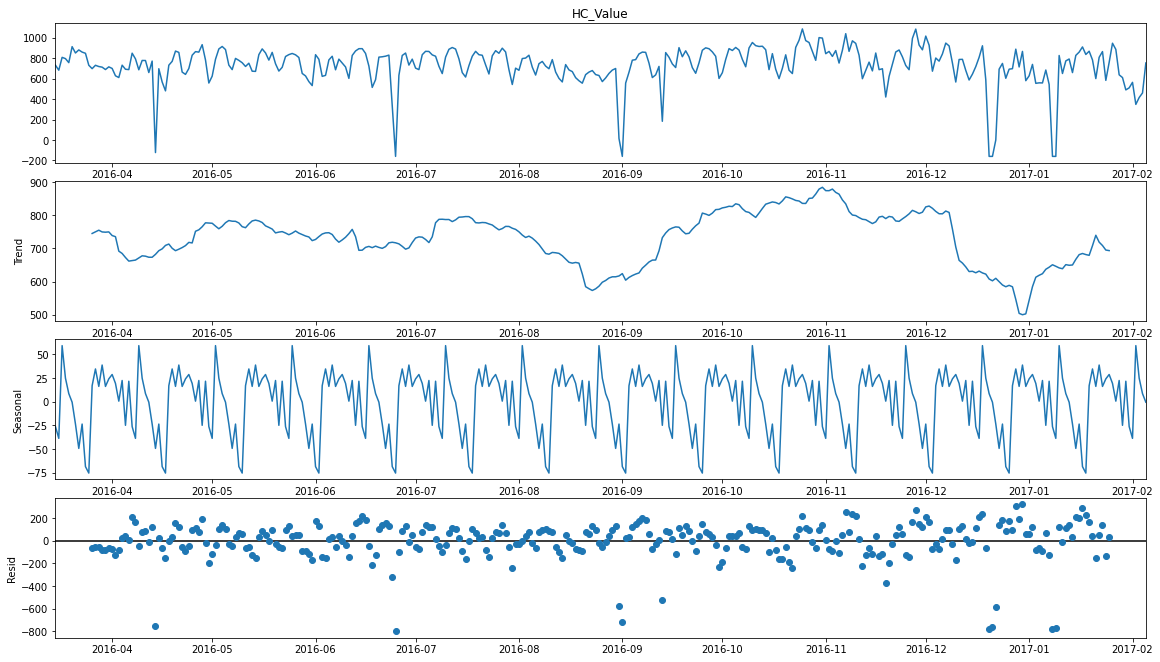

In [28]:
decompose_result_mult = seasonal_decompose(time_decompose.HC_Value, model="additive",period = int(len(time_decompose.HC_Value)/14))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()

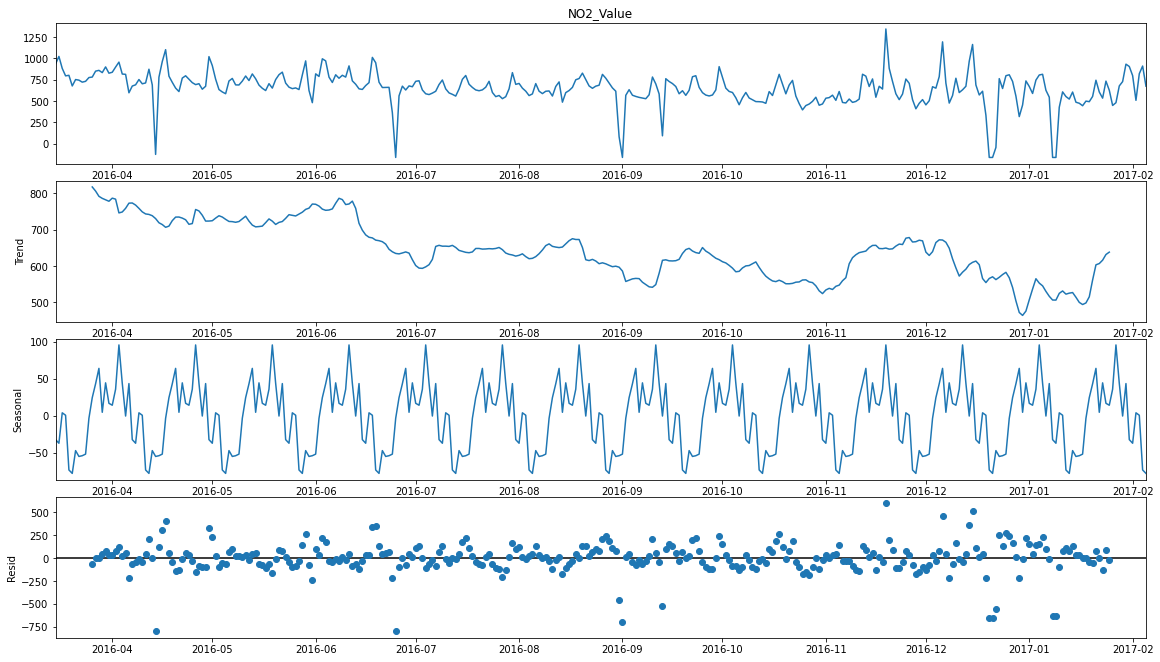

In [29]:
decompose_result_mult = seasonal_decompose(time_decompose.NO2_Value, model="additive",period = int(len(time_decompose.NO2_Value)/14))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()

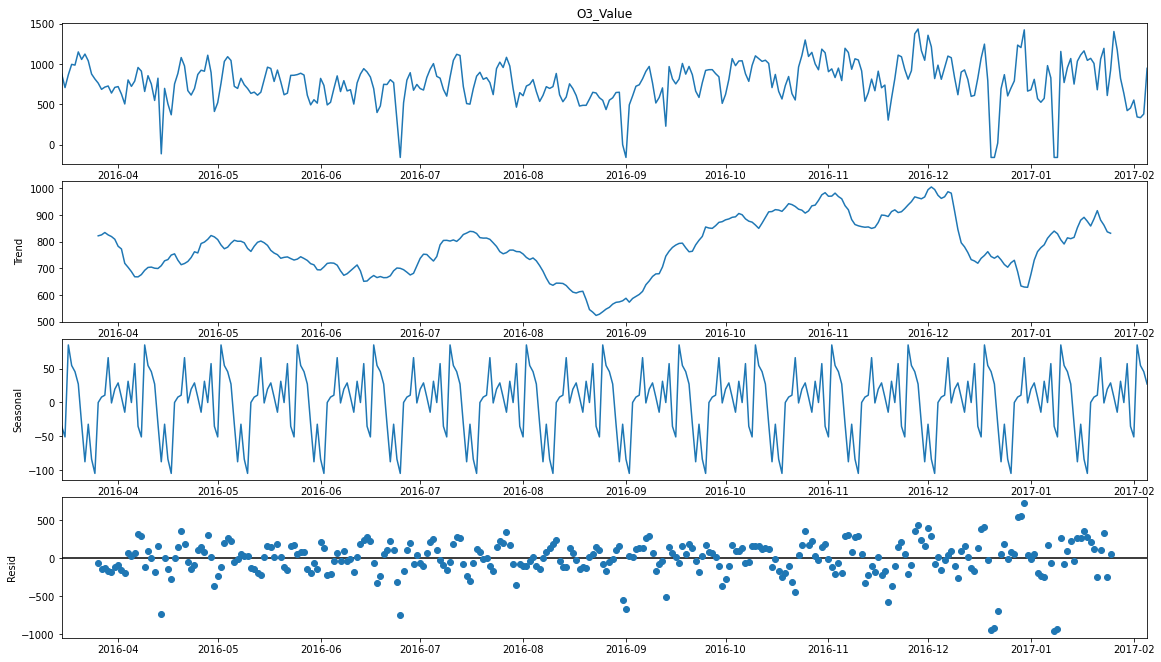

In [30]:
decompose_result_mult = seasonal_decompose(time_decompose.O3_Value, model="additive",period = int(len(time_decompose.O3_Value)/14))
# Period is the number of months in the data set
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig=decompose_result_mult.plot()
fig.set_size_inches((16, 9))
plt.show()

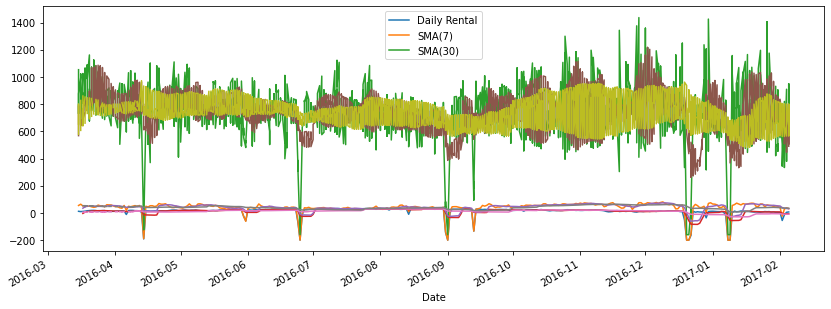

In [31]:
# rolling 
daily_rental = airtrain
ax = daily_rental.plot(figsize=(14, 5))
daily_rental.rolling(window=7).mean().plot(ax=ax)
daily_rental.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Daily Rental', 'SMA(7)', 'SMA(30)'])
plt.show()

In [32]:
# pip install statsmodels

# TimeSeries Models

## Holts Winter Exponential Smoothing Function

In [33]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
model = Ridge()
# let x be the airtrain dataframe without value 
# let y be the airtrain dataframe with value
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)
CO = airtrain[airtrain.Gas=='CO'].drop(['Gas'],axis=1).Value
HC = airtrain[airtrain.Gas=='HC'].drop(['Gas'],axis=1).Value
NO2 = airtrain[airtrain.Gas=='NO2'].drop(['Gas'],axis=1).Value
O3 = airtrain[airtrain.Gas=='O3'].drop(['Gas'],axis=1).Value


# pivot table
test = pd.read_csv('test.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
#drop 5th to 6th column of test
test.drop(test.columns[4:6],axis=1,inplace=True)
#get all gas == to CO,HC,NO2,O3
CO_test= test[test['Gas'] == 'CO']
HC_test= test[test['Gas'] == 'HC']
NO2_test = test[test['Gas'] == 'NO2']
O3_test= test[test['Gas'] == 'O3']

CO_test

id          T         RH Gas
Date                                    
2017-02-06   0   6.616667  51.734375  CO
2017-02-07   1   7.613194  43.930903  CO
2017-02-08   2   7.252083  50.966667  CO
2017-02-09   3   7.473611  50.166319  CO
2017-02-10   4   5.571875  46.604167  CO
...         ..        ...        ...  ..
2017-04-05  58  17.554167  50.092708  CO
2017-04-06  59  15.919792  35.959722  CO
2017-04-07  60  15.489583  32.213542  CO
2017-04-08  61  18.381250  33.686458  CO
2017-04-09  62  16.966667  42.791667  CO

[63 rows x 4 columns]

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
CO_model = HWES(CO, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
CO_model.exog=CO_test[['T','RH']]
CO_pred = CO_model.predict(start='2017-02-06', end='2017-04-9')

HC_model = HWES(HC, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
HC_model.exog=HC_test[['T','RH']]
HC_pred = HC_model.predict(start='2017-02-06', end='2017-04-9')


NO2_model = HWES(NO2, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
NO2_model.exog=NO2_test[['T','RH']]
NO2_pred = NO2_model.predict(start='2017-02-06', end='2017-04-9')

O3_model = HWES(O3, seasonal_periods=7, trend='add', seasonal='add',
damped_trend=True, freq='D').fit()
O3_model.exog=O3_test[['T','RH']]
O3_pred = O3_model.predict(start='2017-02-06', end='2017-04-9')


<AxesSubplot:xlabel='Date'>

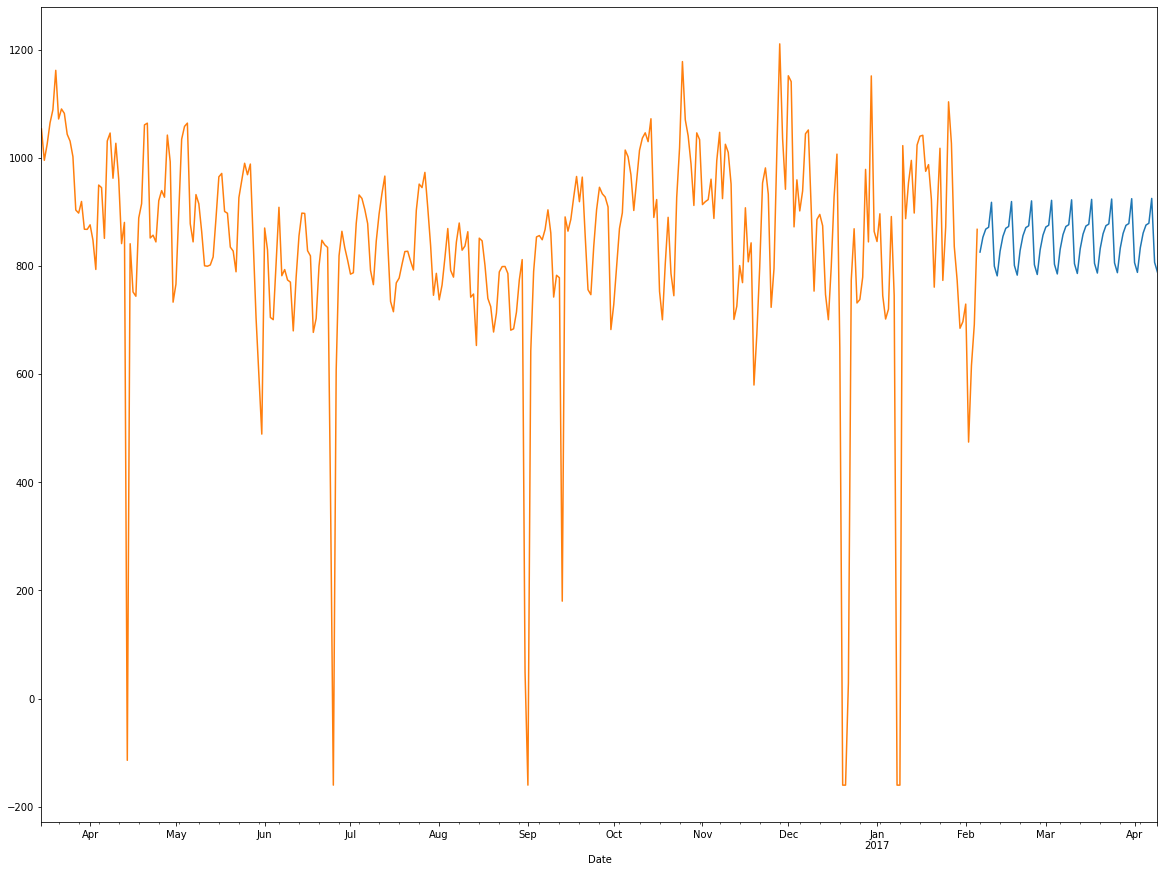

In [35]:
CO_pred.plot()
CO.plot()

In [36]:
# concat CO_pred,HC_pred,NO2_pred,O3_pred
predictions = pd.concat([CO_pred,HC_pred,NO2_pred,O3_pred],axis=0)
predictions = pd.DataFrame(predictions)
#reindex predictions to range(len(predictions))
predictions.index = range(len(predictions))
predictions.index.name='id'
#rename column 1 of predictions to 'Value'
predictions.columns = ['Value']

#if index of y_pred is in (id) then y_pred value is -200
extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
extract200.drop(extract200.columns[3:],axis=1,inplace=True)
#extract the id column of extract200 where "T" or "RH" == -200
ids=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
ids=list(ids)
for x in ids:
    predictions.loc[predictions.index==x,'Value'] = -160



predictions.to_csv('./predictions/holtswinter.csv')

<AxesSubplot:xlabel='id'>

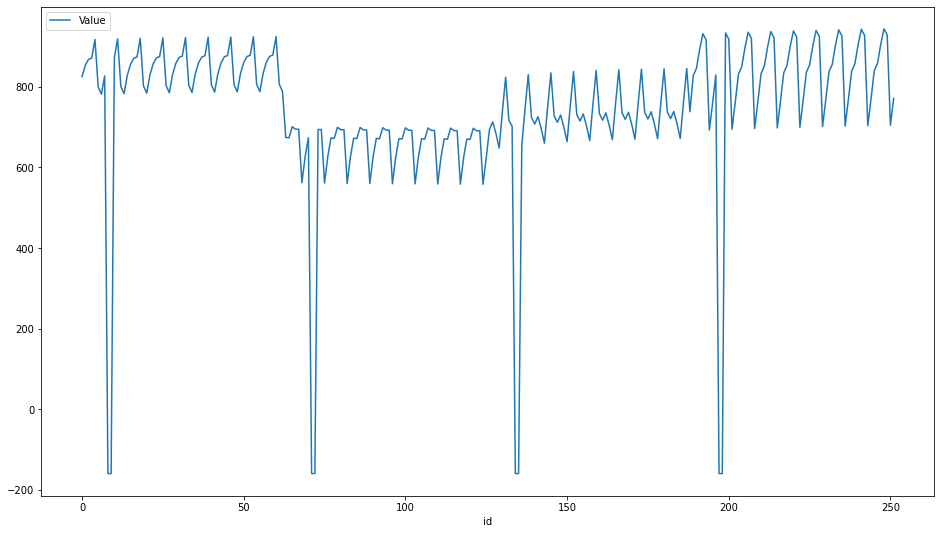

In [37]:
predictions.plot(figsize=(16, 9))

In [38]:
# Code a function in which it tests how good a model is by comparing the actual values to the predicted values
def test_model(model, X, y):
    from sklearn.metrics import mean_absolute_percentage_error
    pred = model.predict(X)
    mape = mean_absolute_percentage_error(y, pred)
    return mape

In [39]:

def convert_cheat(df):
    predictions.index = range(len(predictions))
    predictions.index.name='id'
    #rename column 1 of predictions to 'Value'
    predictions.columns = ['Value']
    #if index of y_pred is in (id) then y_pred value is -200
    extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
    extract200.drop(extract200.columns[3:],axis=1,inplace=True)
    #extract the id column of extract200 where "T" or "RH" == -200
    ids=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
    ids=list(ids)
    for x in ids:
        df.loc[df['id']==x,'Value'] = -160
    return df

## Auto Regressive Integrated Moving Average (ARIMA)

In [40]:
# import data
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)

temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
df

T         RH     CO_Value    HC_Value    NO2_Value  \
Date                                                                     
2016-03-15  12.020833  54.883334  1053.200000  729.800000   933.800000   
2016-03-16   9.833333  64.069791   995.250000  681.441667  1021.750000   
2016-03-17  11.292708  51.107292  1025.250000  806.583333   881.375000   
2016-03-18  12.866319  51.530903  1064.444444  794.258333   794.527778   
2016-03-19  16.016667  48.843750  1088.741667  755.083333   800.883333   
...               ...        ...          ...         ...          ...   
2017-02-01   5.267708  39.614930   729.422222  562.650000   797.647222   
2017-02-02 -55.515972 -24.010417   474.291667  347.480556   508.180556   
2017-02-03 -14.272917  28.563542   615.700000  414.475000   819.733333   
2017-02-04   4.848611  37.832986   691.713889  458.947222   909.375000   
2017-02-05   7.273958  31.809375   867.600000  751.833333   673.741667   

              O3_Value  
Date                    
2016-03-15  876.833333  
2016-03-16  708.025000  
2016-03-17  867.375000  
2016-03-18  996.625000  
2016-03-19  987.341667  
...                ...  
2017-02-01  553.180556  
2017-02-02  343.500000  
2017-02-03  334.458333  
2017-02-04  379.513889  
2017-02-05  947.333333  

[328 rows x 6 columns]

                               SARIMAX Results                                
Dep. Variable:               CO_Value   No. Observations:                  328
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2141.104
Date:                Mon, 08 Aug 2022   AIC                           4290.207
Time:                        16:44:02   BIC                           4305.379
Sample:                    03-15-2016   HQIC                          4296.261
                         - 02-05-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        840.5836     30.305     27.738      0.000     781.187     899.980
ar.L1          0.4033      0.057      7.123      0.000       0.292       0.514
ma.L1          0.2617      0.058      4.511      0.0

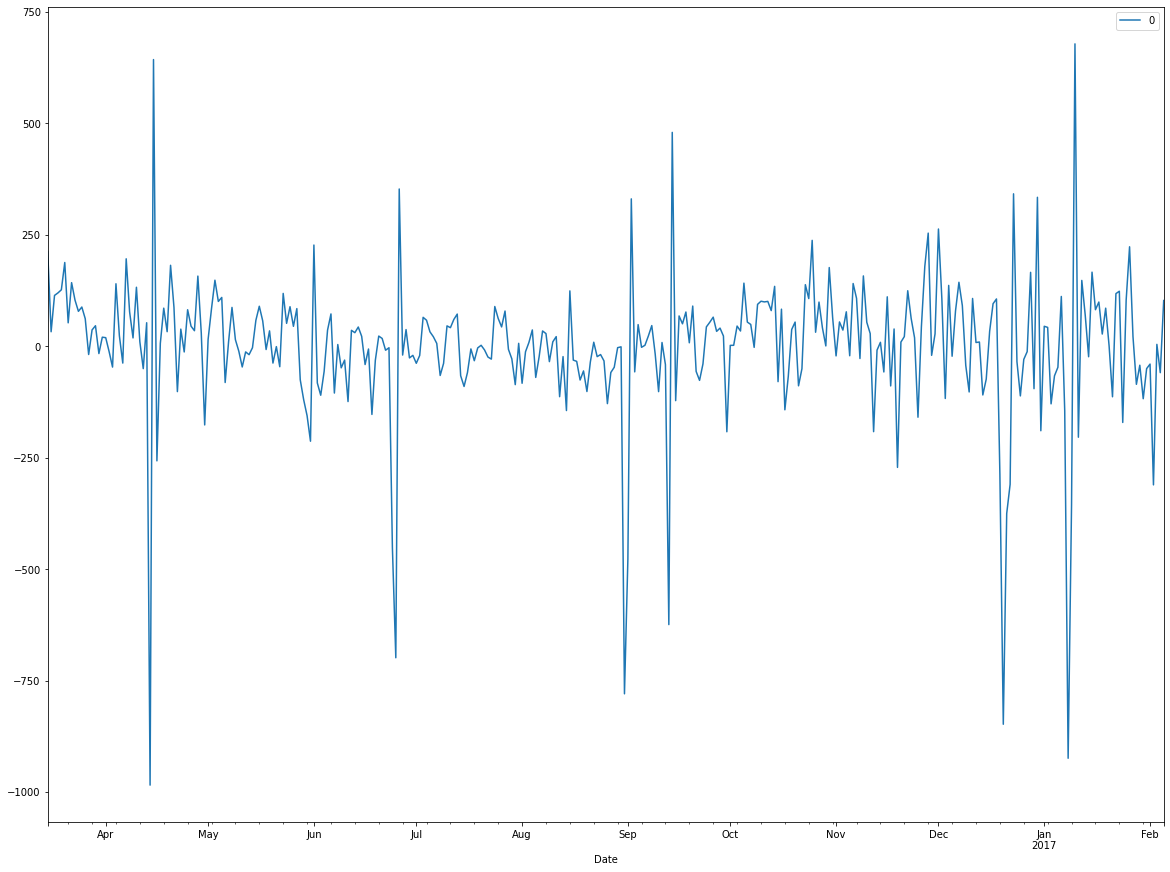

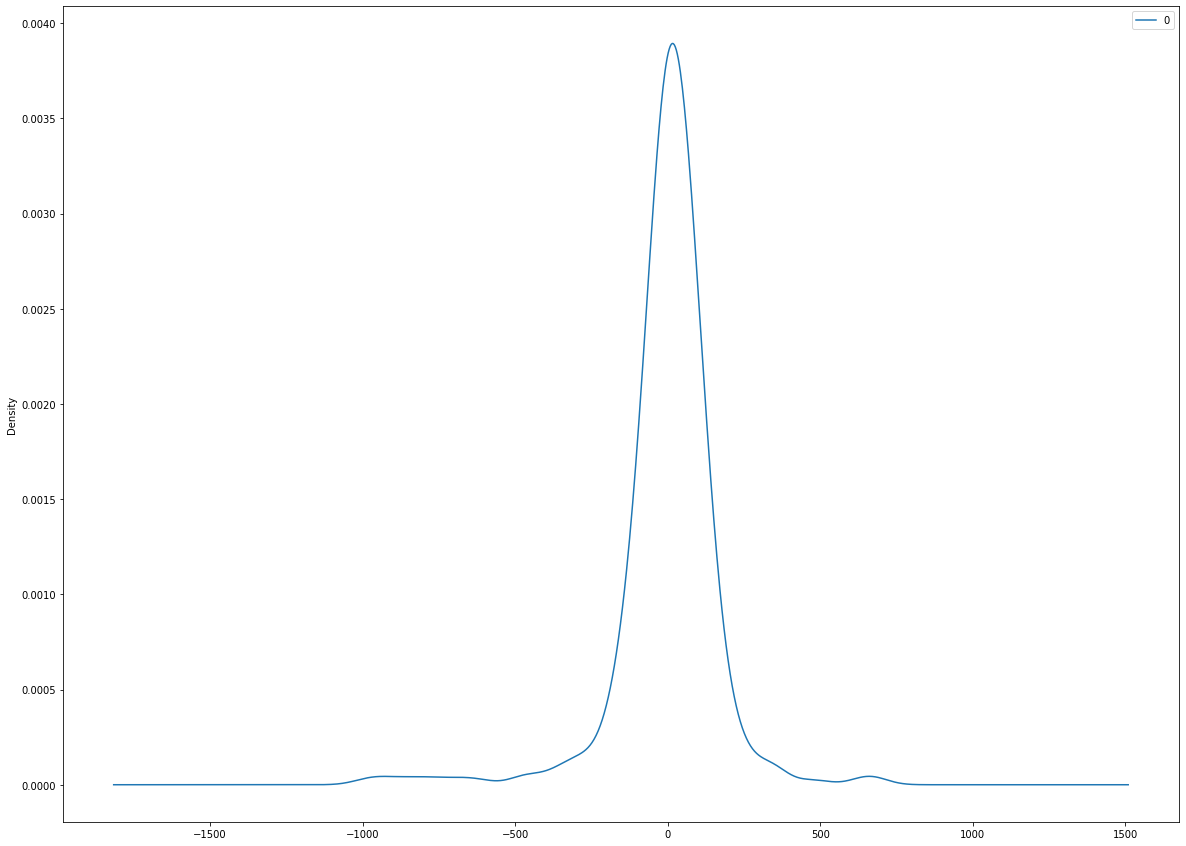

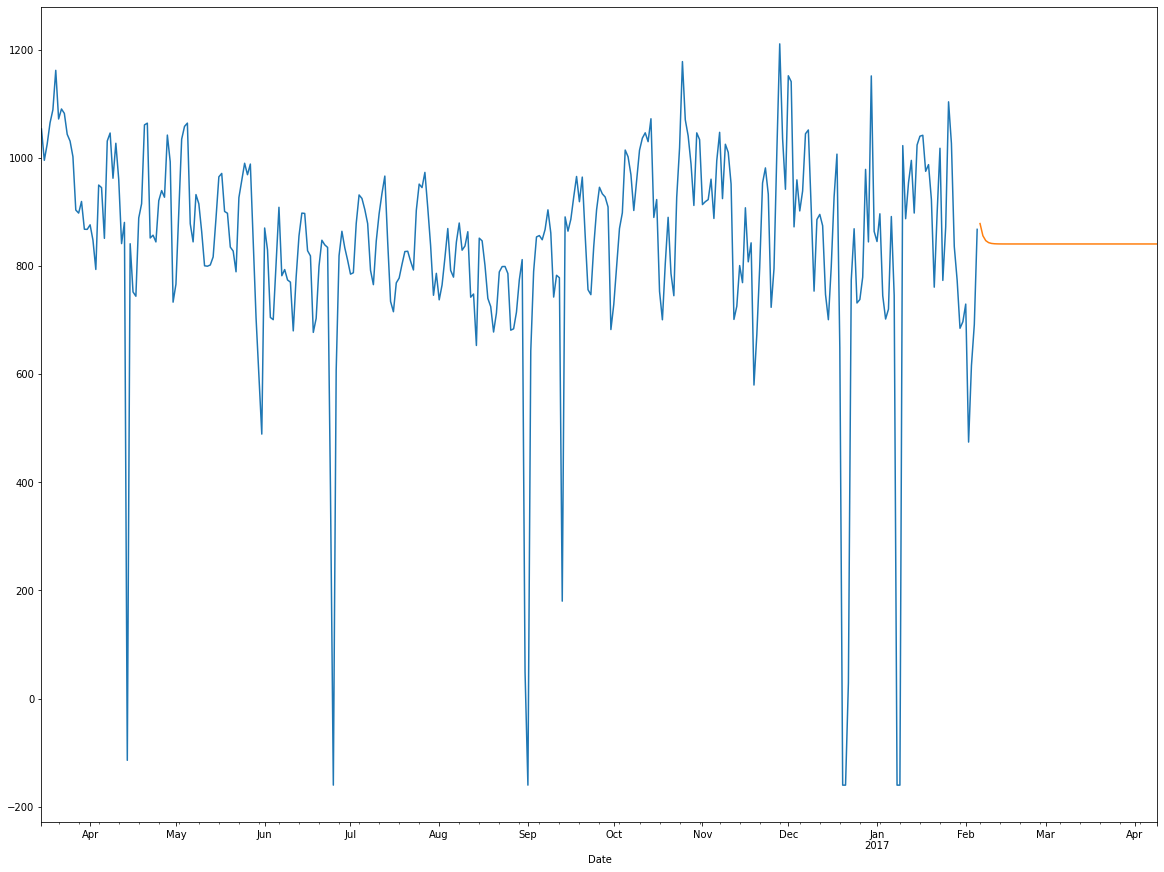

In [196]:
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(df['CO_Value'], order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
# print(residuals.describe())

predict_CO = model_fit.forecast(steps = 63, exog=[['T','RH']])

df.CO_Value.plot()
predict_CO.plot()
plt.show()

### We can see the predictions literally just takes the mean and attempts to predict the next 63 days. We recognise that Arima is not the best model to be predicting

In [42]:
def Framing(CO,HC,NO2,O3):
        Frame = pd.concat([CO,HC,NO2,O3],axis=0,ignore_index= True)
        return Frame


In [43]:
#Function to auto tune 
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
        error = mean_squared_error(test, predictions)
        return error

In [44]:
# Accuracy metrics
# from statsmodels.tsa.stattools import acf
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
#             'corr':corr, 'minmax':minmax})

# forecast_accuracy(fc, test.values)

#> {'mape': 0.02250131357314834,
#>  'me': 3.230783108990054,
#>  'mae': 4.548322194530069,
#>  'mpe': 0.016421001932706705,
#>  'rmse': 6.373238534601827,
#>  'acf1': 0.5105506325288692,
#>  'corr': 0.9674576513924394,
#>  'minmax': 0.02163154777672227}


## Seasonal Auto Regressive Integrated Moving Average (SARIMAX)

In [45]:
# pivot table
test = pd.read_csv('test.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
#drop 5th to 6th column of test
test.drop(test.columns[4:6],axis=1,inplace=True)
#get all gas == to CO,HC,NO2,O3
CO_test= test[test['Gas'] == 'CO']
HC_test= test[test['Gas'] == 'HC']
NO2_test = test[test['Gas'] == 'NO2']
O3_test= test[test['Gas'] == 'O3']


In [46]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['CO_Value'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
CO_pred=results.forecast(steps=63,exog=CO_test[['T','RH']])
# CO_pred.plot()
# df[['CO_Value','forecast']].plot(figsize=(12,8))

# print(results.plot_diagnostics())

c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [47]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['HC_Value'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
HC_pred=results.forecast(steps=63,exog=CO_test[['T','RH']])

c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['NO2_Value'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
NO2_pred=results.forecast(steps=63,exog=CO_test[['T','RH']])

c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [49]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['O3_Value'],order=(2, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
O3_pred=results.forecast(steps=63,exog=CO_test[['T','RH']])

c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [50]:
# concat CO_pred,HC_pred,NO2_pred,O3_pred
predictions = pd.concat([CO_pred,HC_pred,NO2_pred,O3_pred],axis=0)
predictions = pd.DataFrame(predictions)
#reindex predictions to range(len(predictions))
predictions.index = range(len(predictions))
predictions.index.name='id'
#rename column 1 of predictions to 'Value'
predictions.columns = ['Value']

#if index of y_pred is in (id) then y_pred value is -200
extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
extract200.drop(extract200.columns[3:],axis=1,inplace=True)
#extract the id column of extract200 where "T" or "RH" == -200
ids=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
ids=list(ids)
for x in ids:
    predictions.loc[predictions.index==x,'Value'] = -160



predictions.to_csv('./predictions/sarimax_notune.csv')

<AxesSubplot:xlabel='Date'>

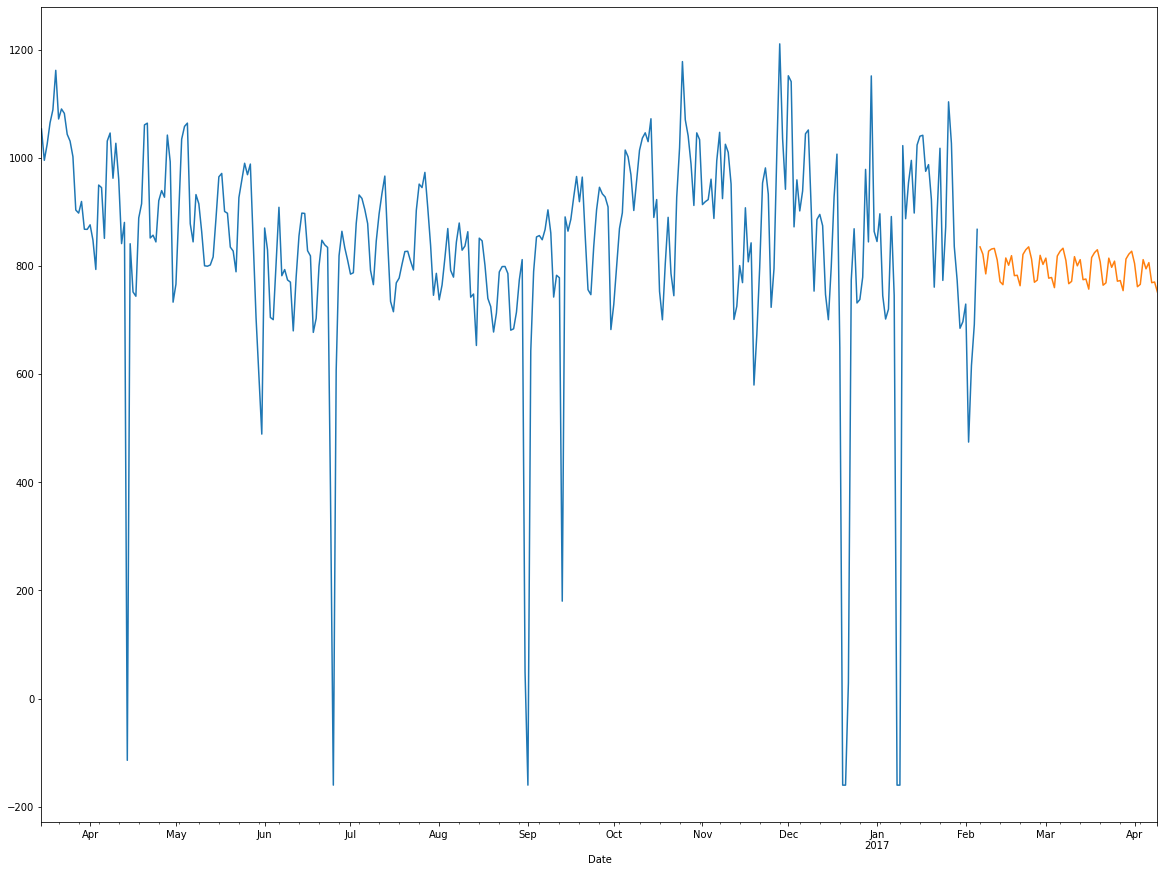

In [51]:
df.CO_Value.plot()
CO_pred.plot()

# Vector Auto Regressive Integrated Moving Average (VARIMAX)
### Of all the models i think Varimax would perform the best , it is made to take in multiple explanatory variables just like the pollution dataset that we are tackling. It is a multivariate time series and as shown during the eda process, there is indeed correlation between the Gas Values and (T,RH). 

In [55]:
# Importing all necessary modules
from sklearn.model_selection import TimeSeriesSplit
import warnings
from itertools import combinations_with_replacement
from itertools import product
from sklearn.metrics import mean_squared_error

airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)

temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value')
df = temp.join([rh, pivot])
df.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)


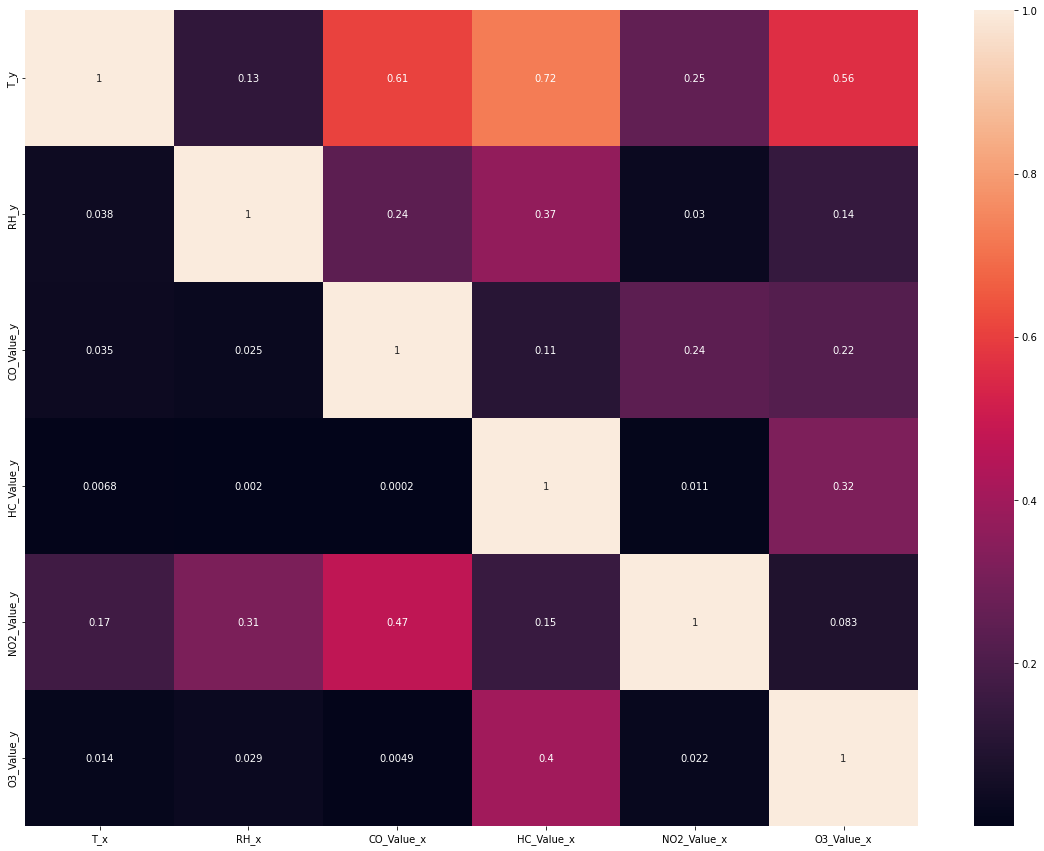

In [195]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

corr = grangers_causation_matrix(df, variables = df.columns)
sns.heatmap(corr,annot=True)
plt.show()

### On top of the correlation test I did previously , the grangers causation matrix also show that the variables are interchangeably causing one another

### Before continuing, I will split the data into 80% and 20% 

In [200]:
# spliting into exogenous (X) and endog (y) variables
X, y = df[['T', 'RH']], df.drop(['T', 'RH'], axis=1)
print(X.shape, y.shape)
# split into 8:2 train:test
train_size = int(len(df) * 0.8)
X_train= X[:train_size]
X_test = X[train_size:]
y_train= y[:train_size]
y_test =y[train_size:]
print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')

(328, 2) (328, 4)
X_train.shape = (262, 2), y_train.shape = (262, 4)
X_test.shape = (66, 2), y_test.shape = (66, 4)


In [222]:
# Firstly will try and predict on the split dataset and see how well it fares against the actual data
trial = VARMAX(endog=y_train, order=(1, 0), exog=X_train)
results = trial.fit(maxiter=100, disp=False)
print(results.summary())
# print(results.description())


                                           Statespace Model Results                                          
Dep. Variable:     ['CO_Value', 'HC_Value', 'NO2_Value', 'O3_Value']   No. Observations:                  262
Model:                                                       VARX(1)   Log Likelihood               -6461.905
                                                         + intercept   AIC                          12999.810
Date:                                               Mon, 08 Aug 2022   BIC                          13135.407
Time:                                                       18:07:28   HQIC                         13054.310
Sample:                                                   03-15-2016                                         
                                                        - 12-01-2016                                         
Covariance Type:                                                 opg                                         
Ljung-Box 

In [ ]:
%%time
warnings.filterwarnings("ignore")
def VARMAX_cv(exog, endog, order=(1, 0), splits=3):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    tscv = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in tscv.split(exog):
        X_train, X_test = exog.iloc[train_index], exog.iloc[test_index]
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        
        model = VARMAX(endog=y_train, exog=X_train, order=order).fit(maxiter=1000, disp=False)
        # validation set
        y_pred = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        # testing set
        train_pred = model.predict(start=X_train.index[0], end=X_train.index[-1], exog=X_train)
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
    # returns mean and standard deviation
    return pd.Series({"train_rmse": np.mean(train_rmse), 'train_rmse_std': np.std(train_rmse), "valid_rmse": np.mean(valid_rmse), 
        'valid_rmse_std': np.std(valid_rmse), "train_mape": np.mean(train_mape), "valid_mape": np.mean(valid_mape), 
        'AIC': model.aic, 'BIC': model.bic}, name=order)

VARMAX_cv(exog=X_clean, endog=y_clean, splits=5, order=(1, 1))

In [223]:
#code out a varmax cross validation function with time series 
def varmax_cross_validation(exogenous,endogenous,order,splits):
    valid_rmse = []
    valid_mape = []
    valid_mae = []
    train_rmse = []
    train_mape = []
    train_mae = []

    tscv = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in tscv.split(exogenous):
        X_train, X_test = exogenous.iloc[train_index], exogenous.iloc[test_index]
        y_train, y_test = endogenous.iloc[train_index], endogenous.iloc[test_index]
        
        model = VARMAX(endog=y_train, exog=X_train, order=order).fit(maxiter=1000, disp=False)
        # validation set
        y_pred = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        valid_mae.append(mean_absolute_error(y_test, y_pred))
        # testing set
        train_pred = model.predict(start=X_train.index[0], end=X_train.index[-1], exog=X_train)
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
        train_mae.append(mean_absolute_error(y_train, train_pred))
    # returns mean and standard deviation
    return pd.Series({"train_rmse": np.mean(train_rmse), 'train_rmse_std': np.std(train_rmse), "valid_rmse": np.mean(valid_rmse), 
        'valid_rmse_std': np.std(valid_rmse), "train_mape": np.mean(train_mape), "valid_mape": np.mean(valid_mape), 
        'AIC': model.aic, 'BIC': model.bic}, name=order)
        
# varmax_cross_validation(exogenous=X_clean,endogenous=y_clean,order=(1,1),splits=3)
    


train_rmse          113.628631
train_rmse_std       17.890995
valid_rmse          180.996702
valid_rmse_std       21.589126
train_mape            0.259669
valid_mape            0.871685
AIC               10710.577187
BIC               10899.865090
Name: (1, 1), dtype: float64

In [225]:
from statsmodels.tsa.statespace.varmax import VARMAX
model = VARMAX(endog=y_train, exog=X_train)

lags = range(0,4)
error = range(0,10)
AIC = []
for i,j in list(product(lags,error)):
    result = model.fit(order = (i,j), trend='c')
    print('Lag Order =', (i,j))
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('HQIC: ', result.hqic)
    print('mae:', result.mae)
    print('mse',result.mse,'\n')

Lag Order = (0, 0)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 1)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 2)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 3)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 4)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 5)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.39450447822 

Lag Order = (0, 6)
AIC :  13837.275588344812
BIC :  13972.872679487733
HQIC:  13891.775020628138
mae: 102.7344078940949
mse 84225.394504

In [78]:

# create train and validatation set
train_clean_pred = model.predict(start=X_clean_train.index[0], end=X_clean_train.index[-1], exog=X_clean_train)
valid_clean_pred = model.predict(start=X_clean_test.index[0], end=X_clean_test.index[-1], exog=X_clean_test)

# print out metrics
print('Train MAPE:\t{:.3f}%'.format(mean_absolute_percentage_error(y_clean_train, train_clean_pred)*100))
print('Train RMSE:\t{:.3f}'.format(mean_squared_error(y_clean_train, train_clean_pred, squared=False)))
print('Hold Out MAPE:\t{:.3f}%'.format(mean_absolute_percentage_error(y_clean_test, valid_clean_pred)*100))
print('Hold Out RMSE:\t{:.3f}'.format(mean_squared_error(y_clean_test, valid_clean_pred, squared=False)))

Train MAPE:	30.635%
Train RMSE:	101.353
Hold Out MAPE:	355.643%
Hold Out RMSE:	167.683


c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1783: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


## Performing Expanding CV

In [80]:
from sklearn.model_selection import TimeSeriesSplit
import warnings
from itertools import combinations_with_replacement
from itertools import product

In [219]:
%%time
warnings.filterwarnings("ignore")
def VARMAX_cv(exog, endog, order=(1, 1), splits=3):
    valid_rmse = []
    valid_mape = []
    train_rmse = []
    train_mape = []
    tscv = TimeSeriesSplit(n_splits=splits)
    for train_index, test_index in tscv.split(exog):
        X_train, X_test = exog.iloc[train_index], exog.iloc[test_index]
        y_train, y_test = endog.iloc[train_index], endog.iloc[test_index]
        
        model = VARMAX(endog=y_train, exog=X_train, order=order).fit(maxiter=1000, disp=False)
        # validation set
        y_pred = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
        valid_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        valid_mape.append(mean_absolute_percentage_error(y_test, y_pred))
        # testing set
        train_pred = model.predict(start=X_train.index[0], end=X_train.index[-1], exog=X_train)
        train_rmse.append(mean_squared_error(y_train, train_pred, squared=False))
        train_mape.append(mean_absolute_percentage_error(y_train, train_pred))
    # returns mean and standard deviation
    return pd.Series({"train_rmse": np.mean(train_rmse), 'train_rmse_std': np.std(train_rmse), "valid_rmse": np.mean(valid_rmse), 
        'valid_rmse_std': np.std(valid_rmse), "train_mape": np.mean(train_mape), "valid_mape": np.mean(valid_mape), 
        'AIC': model.aic, 'BIC': model.bic}, name=order)

VARMAX_cv(exog=X_clean, endog=y_clean, splits=5, order=(1, 1))

CPU times: total: 11min 8s
Wall time: 10min 43s


train_rmse          116.055353
train_rmse_std       22.541425
valid_rmse          170.475979
valid_rmse_std       30.584804
train_mape            0.230662
valid_mape            0.421888
AIC               12099.234544
BIC               12294.343461
Name: (1, 1), dtype: float64

In [82]:
%%time
scores_df = pd.DataFrame()
p = np.arange(0, 3)
q = np.arange(0, 3)
for i in list(product(p, q)):
    print('Computing (p, q):', i)
    try:
        scores_df[i] = VARMAX_cv(order=i, splits=5, exog=X_clean, endog=y_clean)
    except Exception as e:
        print('Error computing (p, q):', i)
        print(e)
        pass

Computing (p, q): (0, 0)
Error computing (p, q): (0, 0)
Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
Computing (p, q): (0, 1)
Computing (p, q): (0, 2)
Computing (p, q): (1, 0)
Computing (p, q): (1, 1)
Computing (p, q): (1, 2)
Computing (p, q): (2, 0)
Computing (p, q): (2, 1)
Computing (p, q): (2, 2)
CPU times: total: 1h 44min 48s
Wall time: 7h 42min 6s


In [83]:
scores_df.T.style.highlight_min(
    color='blue', axis=0).highlight_max(color='red', axis=0)


## Now lets fit varmax to the whole data and attempt to forecast  we will use order (0,2)
since it produced a low AIC and also generally lowest errors in rmse and mape 

In [151]:
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)

temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value')
analyse = temp.join([rh, pivot])
analyse.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
# take CO_Value and HC_Value and NO2_Value and O3_Value
analyse_endog=analyse.drop(['T','RH'],axis=1)
analyse_exog = analyse.drop(['CO_Value','HC_Value','NO2_Value','O3_Value'],axis=1)


analyse_exog

T         RH
Date                            
2016-03-15  12.020833  54.883334
2016-03-16   9.833333  64.069791
2016-03-17  11.292708  51.107292
2016-03-18  12.866319  51.530903
2016-03-19  16.016667  48.843750
...               ...        ...
2017-02-01   5.267708  39.614930
2017-02-02 -55.515972 -24.010417
2017-02-03 -14.272917  28.563542
2017-02-04   4.848611  37.832986
2017-02-05   7.273958  31.809375

[328 rows x 2 columns]

In [152]:
# pivot table
test = pd.read_csv('test.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)
#drop 5th to 6th column of test
test.drop(test.columns[4:6],axis=1,inplace=True)

# group test data by Date,T and RH
test.drop(['id','Gas'],axis=1,inplace=True)
temp = pd.DataFrame(test['T'].groupby(['Date']).mean())
rh = pd.DataFrame(test['RH'].groupby(['Date']).mean())
test = temp.join([rh])

test


T         RH
Date                            
2017-02-06   6.616667  51.734375
2017-02-07   7.613194  43.930903
2017-02-08   7.252083  50.966667
2017-02-09   7.473611  50.166319
2017-02-10   5.571875  46.604167
...               ...        ...
2017-04-05  17.554167  50.092708
2017-04-06  15.919792  35.959722
2017-04-07  15.489583  32.213542
2017-04-08  18.381250  33.686458
2017-04-09  16.966667  42.791667

[63 rows x 2 columns]

Text(0.5, 1.0, 'Predicted Gas Values')

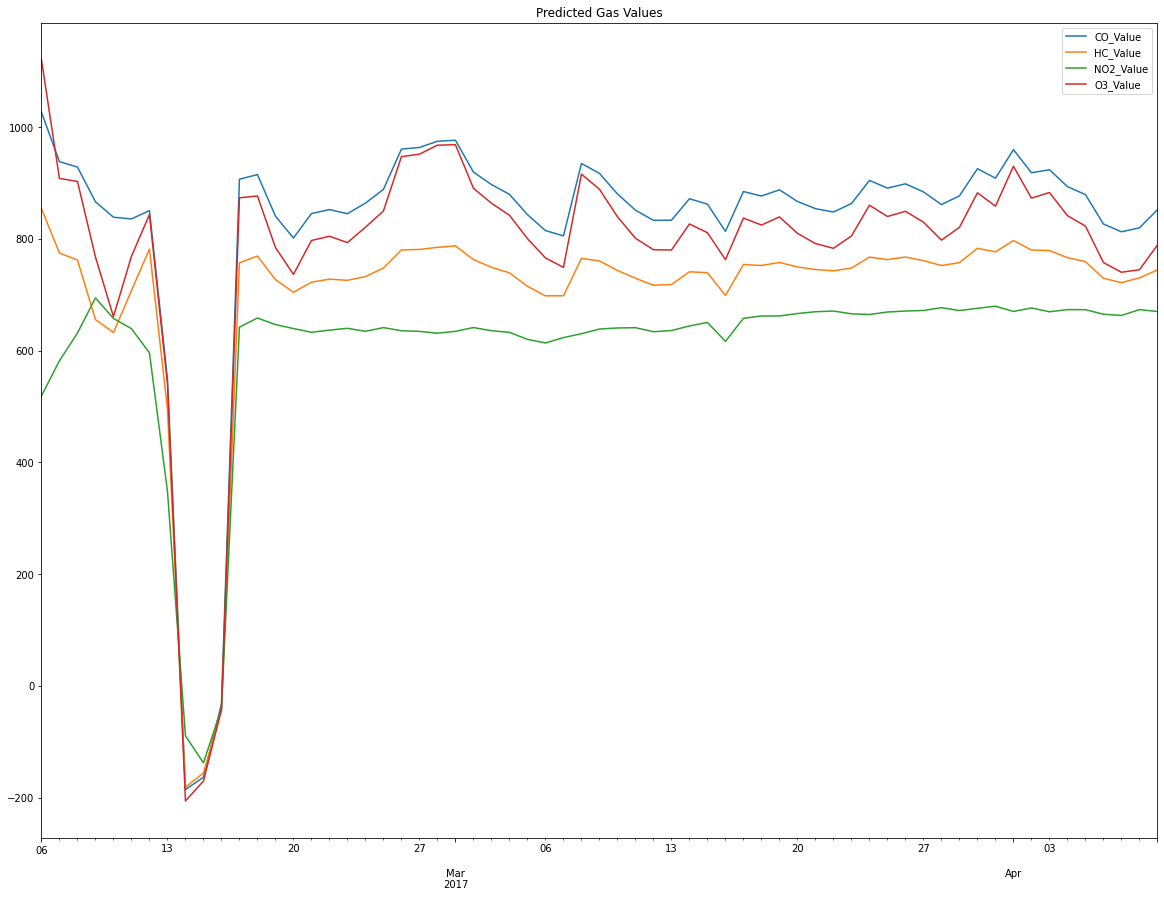

In [188]:
model = VARMAX(endog=analyse_endog, exog=analyse_exog, order=(0, 9), trend='c').fit(maxiter=1000, disp=False)
# generate predictions
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test)
predictions.plot()
plt.title('Predicted Gas Values')


In [189]:
predictions.index.name='Date'
predictions

CO_Value    HC_Value   NO2_Value     O3_Value
Date                                                        
2017-02-06  1026.658594  854.212845  518.962192  1120.785297
2017-02-07   938.199058  774.629221  581.896539   908.189122
2017-02-08   928.550172  762.258430  631.498902   902.877581
2017-02-09   866.456737  655.654629  694.416583   767.719681
2017-02-10   838.810393  632.363012  657.621128   660.856109
...                 ...         ...         ...          ...
2017-04-05   879.276048  759.292887  673.285202   822.912169
2017-04-06   826.670901  729.512594  665.144904   757.631017
2017-04-07   812.728828  721.625033  662.997825   740.324590
2017-04-08   819.827003  730.330775  673.468591   744.792365
2017-04-09   852.252926  744.437179  669.988020   788.967776

[63 rows x 4 columns]

In [190]:
# melt CO_Value, HC_Value, NO2_Value, O3_Value into one column
# predictions.drop('Value',axis=1,inplace=True)

predictions = pd.melt(predictions, value_vars=['CO_Value', 'HC_Value', 'NO2_Value', 'O3_Value'], value_name='Value')
predictions.drop('variable',axis=1,inplace=True)

predictions = pd.DataFrame(predictions)
#reindex predictions to range(len(predictions))
predictions.index = range(len(predictions))
predictions.index.name='id'
#rename column 1 of predictions to 'Value'
predictions.columns = ['Value']
#if index of y_pred is in (id) then y_pred value is -200
extract200 = pd.read_csv('test.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)
extract200.drop(extract200.columns[3:],axis=1,inplace=True)
#extract the id column of extract200 where "T" or "RH" == -200
ids=extract200[((extract200['T']==-200) | (extract200["RH"] ==-200))].id
ids=list(ids)
for x in ids:
    predictions.loc[predictions.index==x,'Value'] = -160

predictions.to_csv('./predictions/varmax_tuned.csv')

<AxesSubplot:xlabel='id'>

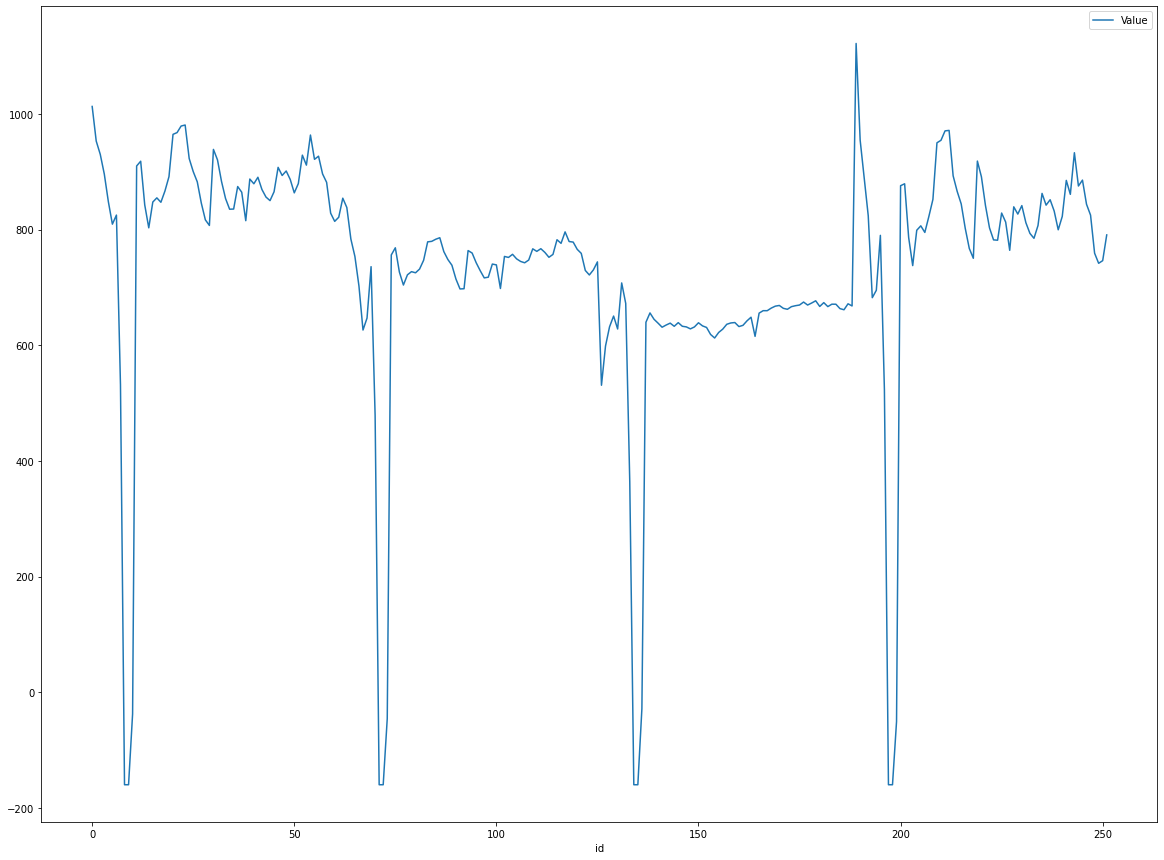

In [187]:
predictions.plot()

In [120]:
# fc = model_fitted.forecast(y=forecast_input, steps=nobs)
# df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
# df_forecast

# Prophet model  
Prophet model is a model designed by facebook , it has a lot lesser parameters than the other models  
I will just try it out and attempt to predict and see how good it is

In [6]:
# pip install prophet

In [141]:
# import data
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[5:],axis=1,inplace=True)


analyse = pd.pivot_table(airtrain, columns='Gas', values='Value', index=airtrain.index).join(airtrain[['T', 'RH']].resample('d').mean(), how='inner')
analyse.reset_index(drop=False,inplace=True)
analyse.rename(columns={"Date":"ds"},inplace=True)

CO= analyse[['ds','CO']]
CO.rename(columns={"CO":"y"},inplace=True)

HC= analyse[['ds','HC']]
HC.rename(columns={"HC":"y"},inplace=True)

NO2= analyse[['ds','NO2']]
NO2.rename(columns={"NO2":"y"},inplace=True)

O3= analyse[['ds','O3']]
O3.rename(columns={"O3":"y"},inplace=True)


C:\Users\LG\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


14:40:42 - cmdstanpy - INFO - Chain [1] start processing
14:40:42 - cmdstanpy - INFO - Chain [1] done processing
14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:43 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:xlabel='id'>

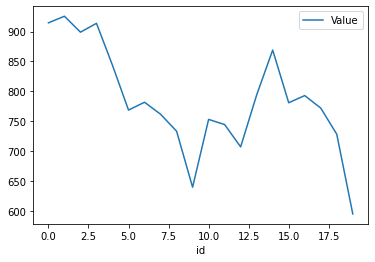

In [142]:
from prophet import Prophet
# prophet model

my_model = Prophet(interval_width=0.95)
my_model.fit(CO)
future_dates = my_model.make_future_dataframe(periods=63, freq='D')
future_dates.head()
forecast = my_model.predict(future_dates)
CO=forecast[['yhat']].head()

my_model = Prophet(interval_width=0.95)
my_model.fit(HC)
future_dates = my_model.make_future_dataframe(periods=63, freq='D')
future_dates.head()
forecast = my_model.predict(future_dates)
HC=forecast[['yhat']].head()

my_model = Prophet(interval_width=0.95)
my_model.fit(NO2)
future_dates = my_model.make_future_dataframe(periods=63, freq='D')
future_dates.head()
forecast = my_model.predict(future_dates)
NO2=forecast[['yhat']].head()

my_model = Prophet(interval_width=1)
my_model.fit(O3)
future_dates = my_model.make_future_dataframe(periods=63, freq='D')
future_dates.head()
forecast = my_model.predict(future_dates)
O3=forecast[['yhat']].head()

prophetic = pd.concat([CO,HC,NO2,O3],axis=0,ignore_index=True)
prophetic.columns = ['Value']
prophetic.index.name='id'
prophetic.plot()

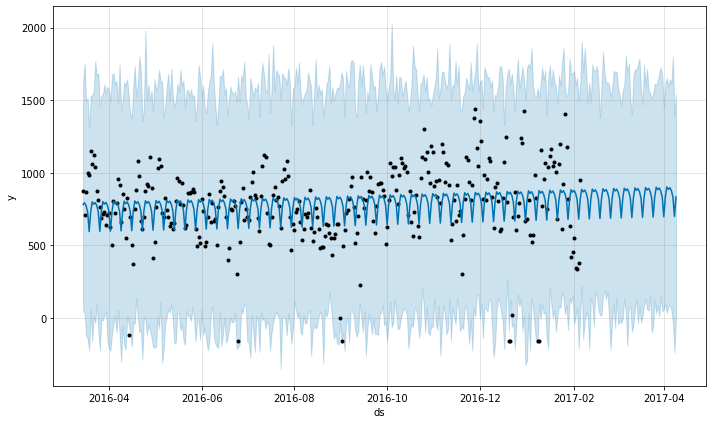

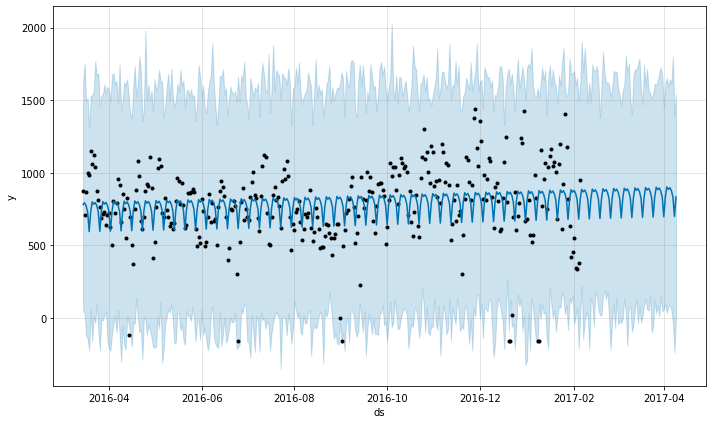

In [143]:
my_model.plot(forecast, uncertainty=True)

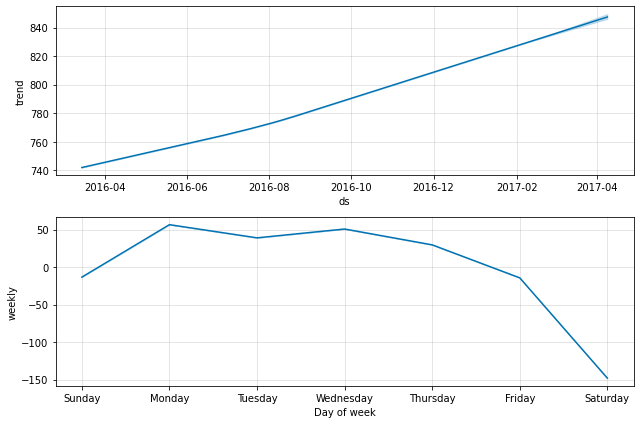

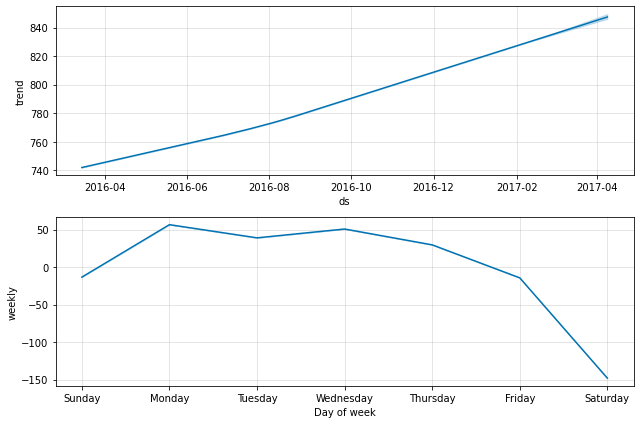

In [144]:
my_model.plot_components(forecast)

### Conclusion:  Prophet is not doing that well for this dataset but it is a much simpler algorithm to use

# Bad Results? Further analysis on Data
### After trying out and tuning models for hours, I couldn't help but wonder if the outliers were affecting the results
### I will be removing the outliers before using the best model that I found previously to forecast.

In [ ]:
# import data
airtrain = pd.read_csv('train.csv',parse_dates=['Date'],index_col='Date',dayfirst=True)

airtrain.drop(airtrain.columns[4:6],axis=1,inplace=True)

# pivot table
# data = pd.read_csv('train.csv',index_col ='Date',parse_dates=['Date'],dayfirst=True)

temp = pd.DataFrame(airtrain['T'].groupby(['Date']).mean())
rh = pd.DataFrame(airtrain['RH'].groupby(['Date']).mean())
pivot = pd.pivot(airtrain, columns = 'Gas', values = 'Value')
analyse = temp.join([rh, pivot])
analyse.rename(columns={"CO":"CO_Value","HC":"HC_Value","NO2":"NO2_Value","O3":"O3_Value"},inplace=True)
analyse

T         RH     CO_Value    HC_Value    NO2_Value  \
Date                                                                     
2016-03-15  12.020833  54.883334  1053.200000  729.800000   933.800000   
2016-03-16   9.833333  64.069791   995.250000  681.441667  1021.750000   
2016-03-17  11.292708  51.107292  1025.250000  806.583333   881.375000   
2016-03-18  12.866319  51.530903  1064.444444  794.258333   794.527778   
2016-03-19  16.016667  48.843750  1088.741667  755.083333   800.883333   
...               ...        ...          ...         ...          ...   
2017-02-01   5.267708  39.614930   729.422222  562.650000   797.647222   
2017-02-02 -55.515972 -24.010417   474.291667  347.480556   508.180556   
2017-02-03 -14.272917  28.563542   615.700000  414.475000   819.733333   
2017-02-04   4.848611  37.832986   691.713889  458.947222   909.375000   
2017-02-05   7.273958  31.809375   867.600000  751.833333   673.741667   

              O3_Value  
Date                    
2016-03-15  876.833333  
2016-03-16  708.025000  
2016-03-17  867.375000  
2016-03-18  996.625000  
2016-03-19  987.341667  
...                ...  
2017-02-01  553.180556  
2017-02-02  343.500000  
2017-02-03  334.458333  
2017-02-04  379.513889  
2017-02-05  947.333333  

[328 rows x 6 columns]

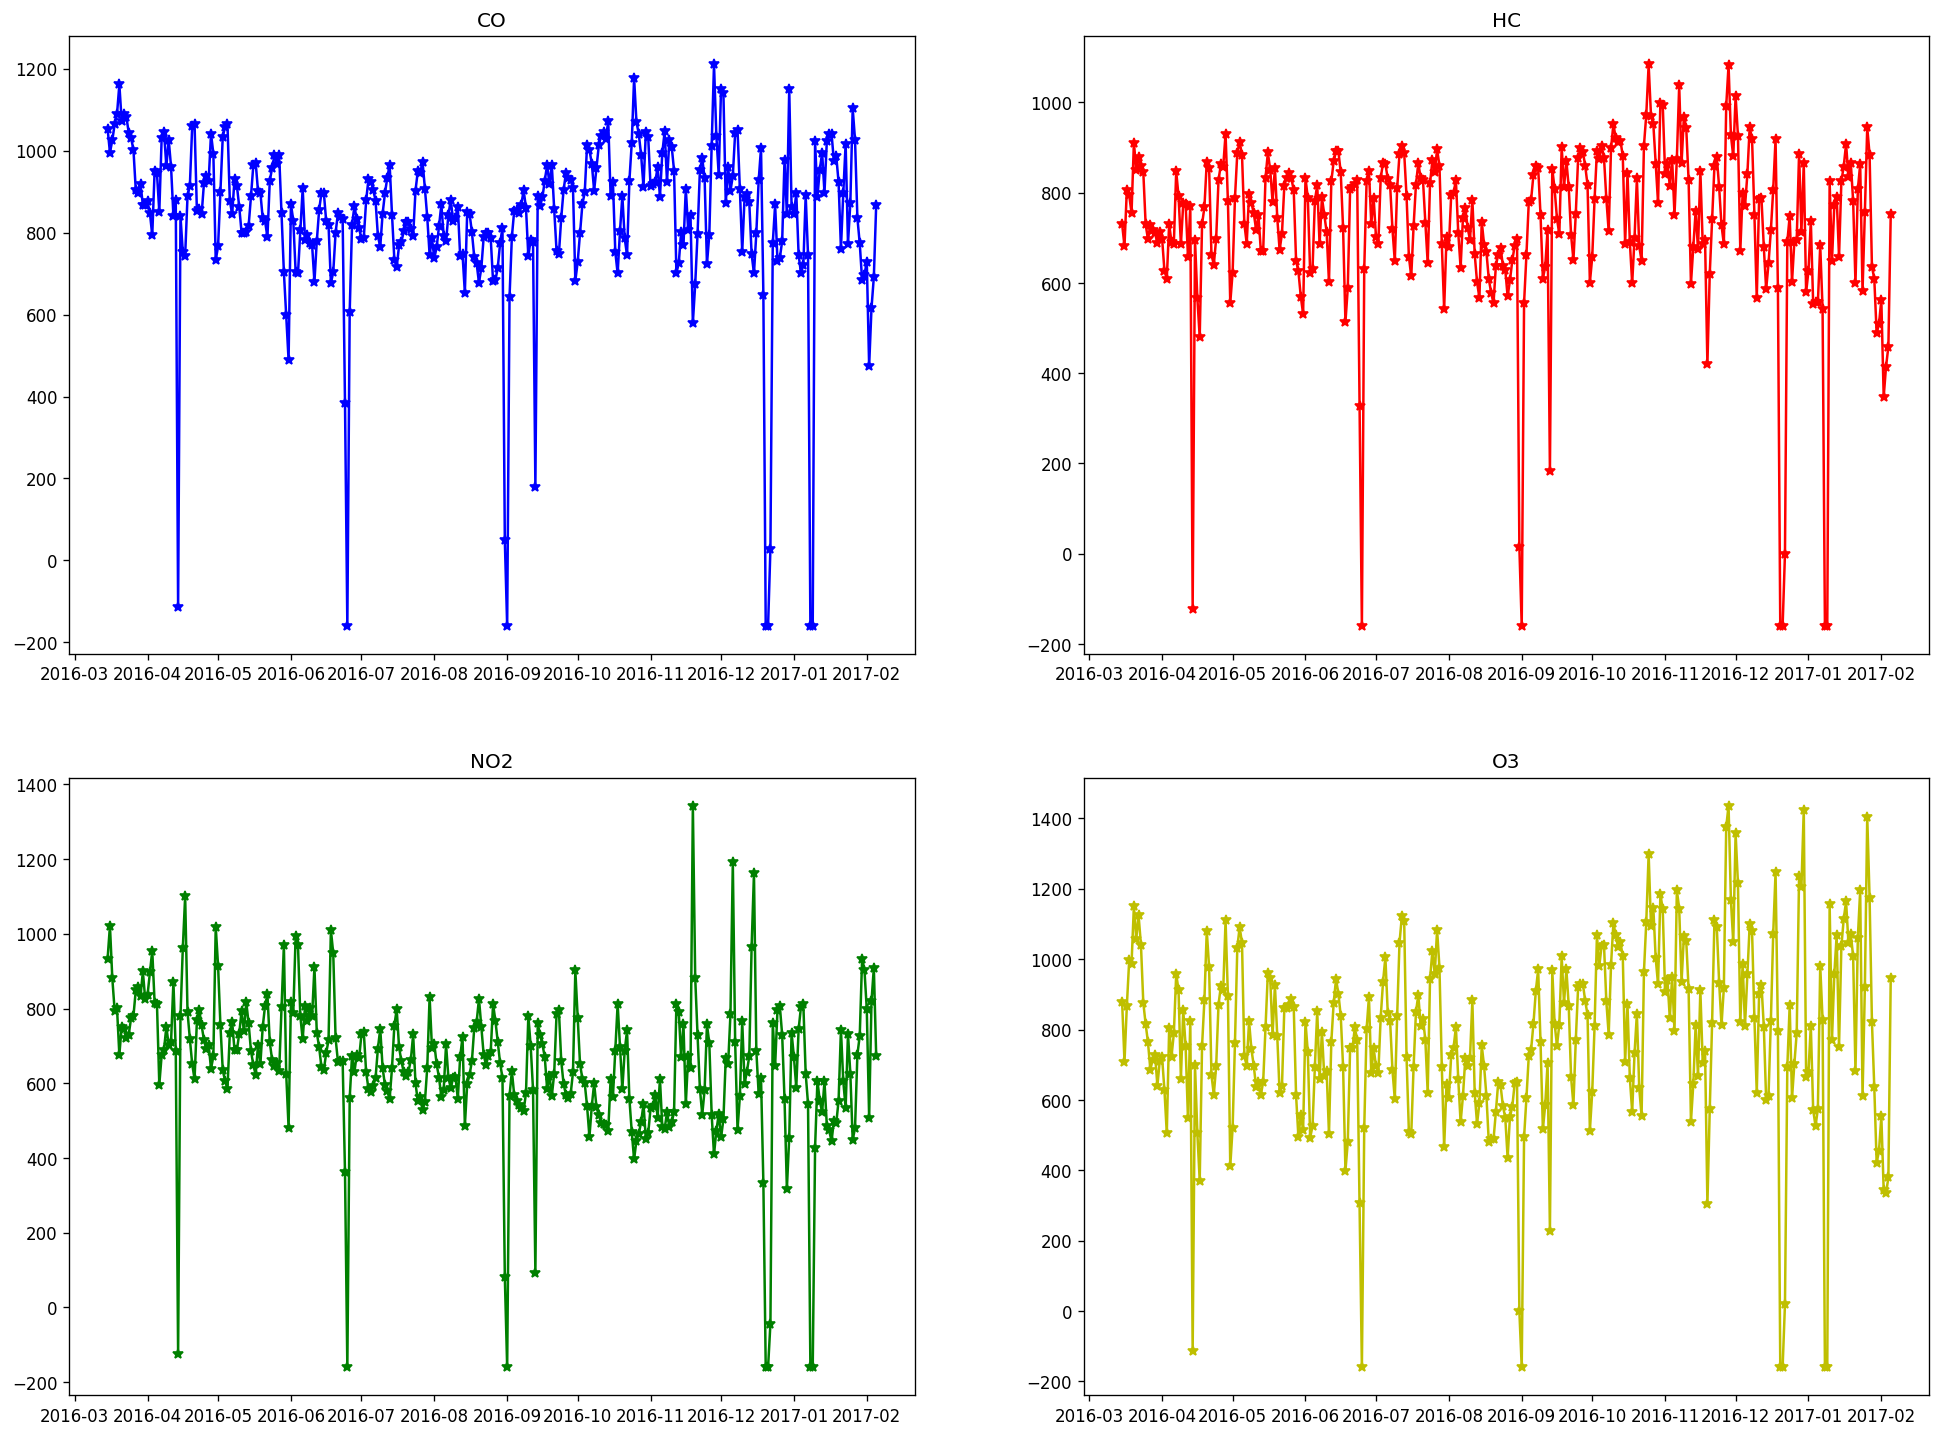

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=2)
axes[0,0].plot(analyse.CO_Value,'b-*');axes[0,0].set_title('CO')
axes[0,1].plot(analyse.HC_Value,'r-*');axes[0,1].set_title('HC')
axes[1,0].plot(analyse.NO2_Value,'g-*');axes[1,0].set_title('NO2')
axes[1,1].plot(analyse.O3_Value,'y-*');axes[1,1].set_title('O3')

plt.show()



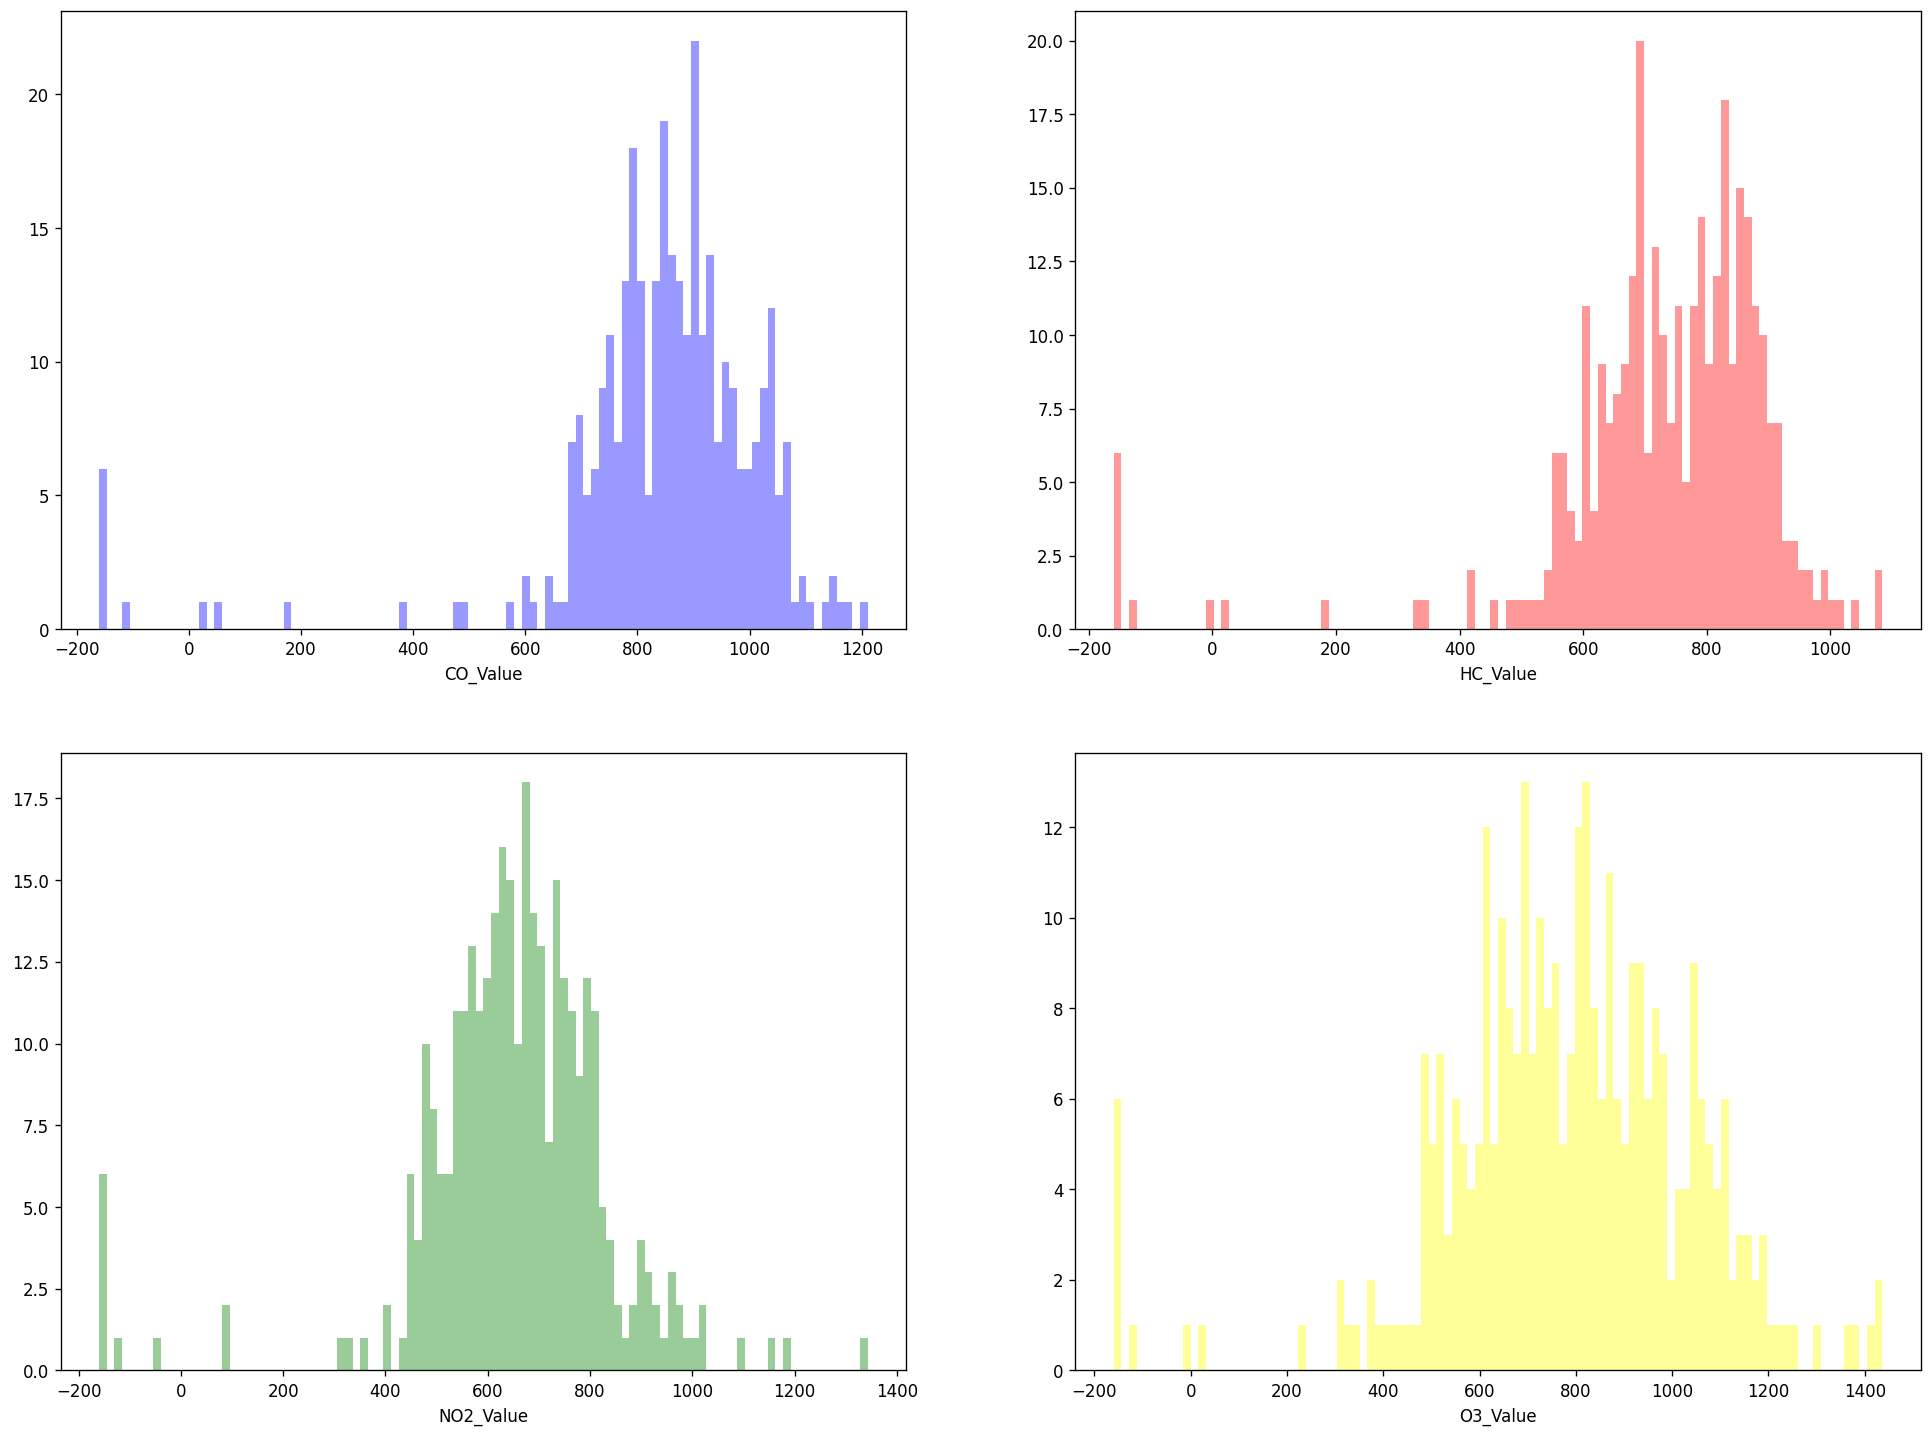

<Figure size 1920x600 with 0 Axes>

In [ ]:

fig,axes = plt.subplots(nrows=2,ncols=2)
plt.figure(figsize=(16,5))
sns.distplot(analyse['CO_Value'],kde=False,color='blue',bins=100,ax=axes[0,0])
sns.distplot(df['HC_Value'],kde=False,color='red',bins=100,ax=axes[0,1])
sns.distplot(analyse['NO2_Value'],kde=False,color='green',bins=100,ax=axes[1,0])
sns.distplot(analyse['O3_Value'],kde=False,color='yellow',bins=100,ax=axes[1,1])

plt.show()

<AxesSubplot:xlabel='O3_Value'>

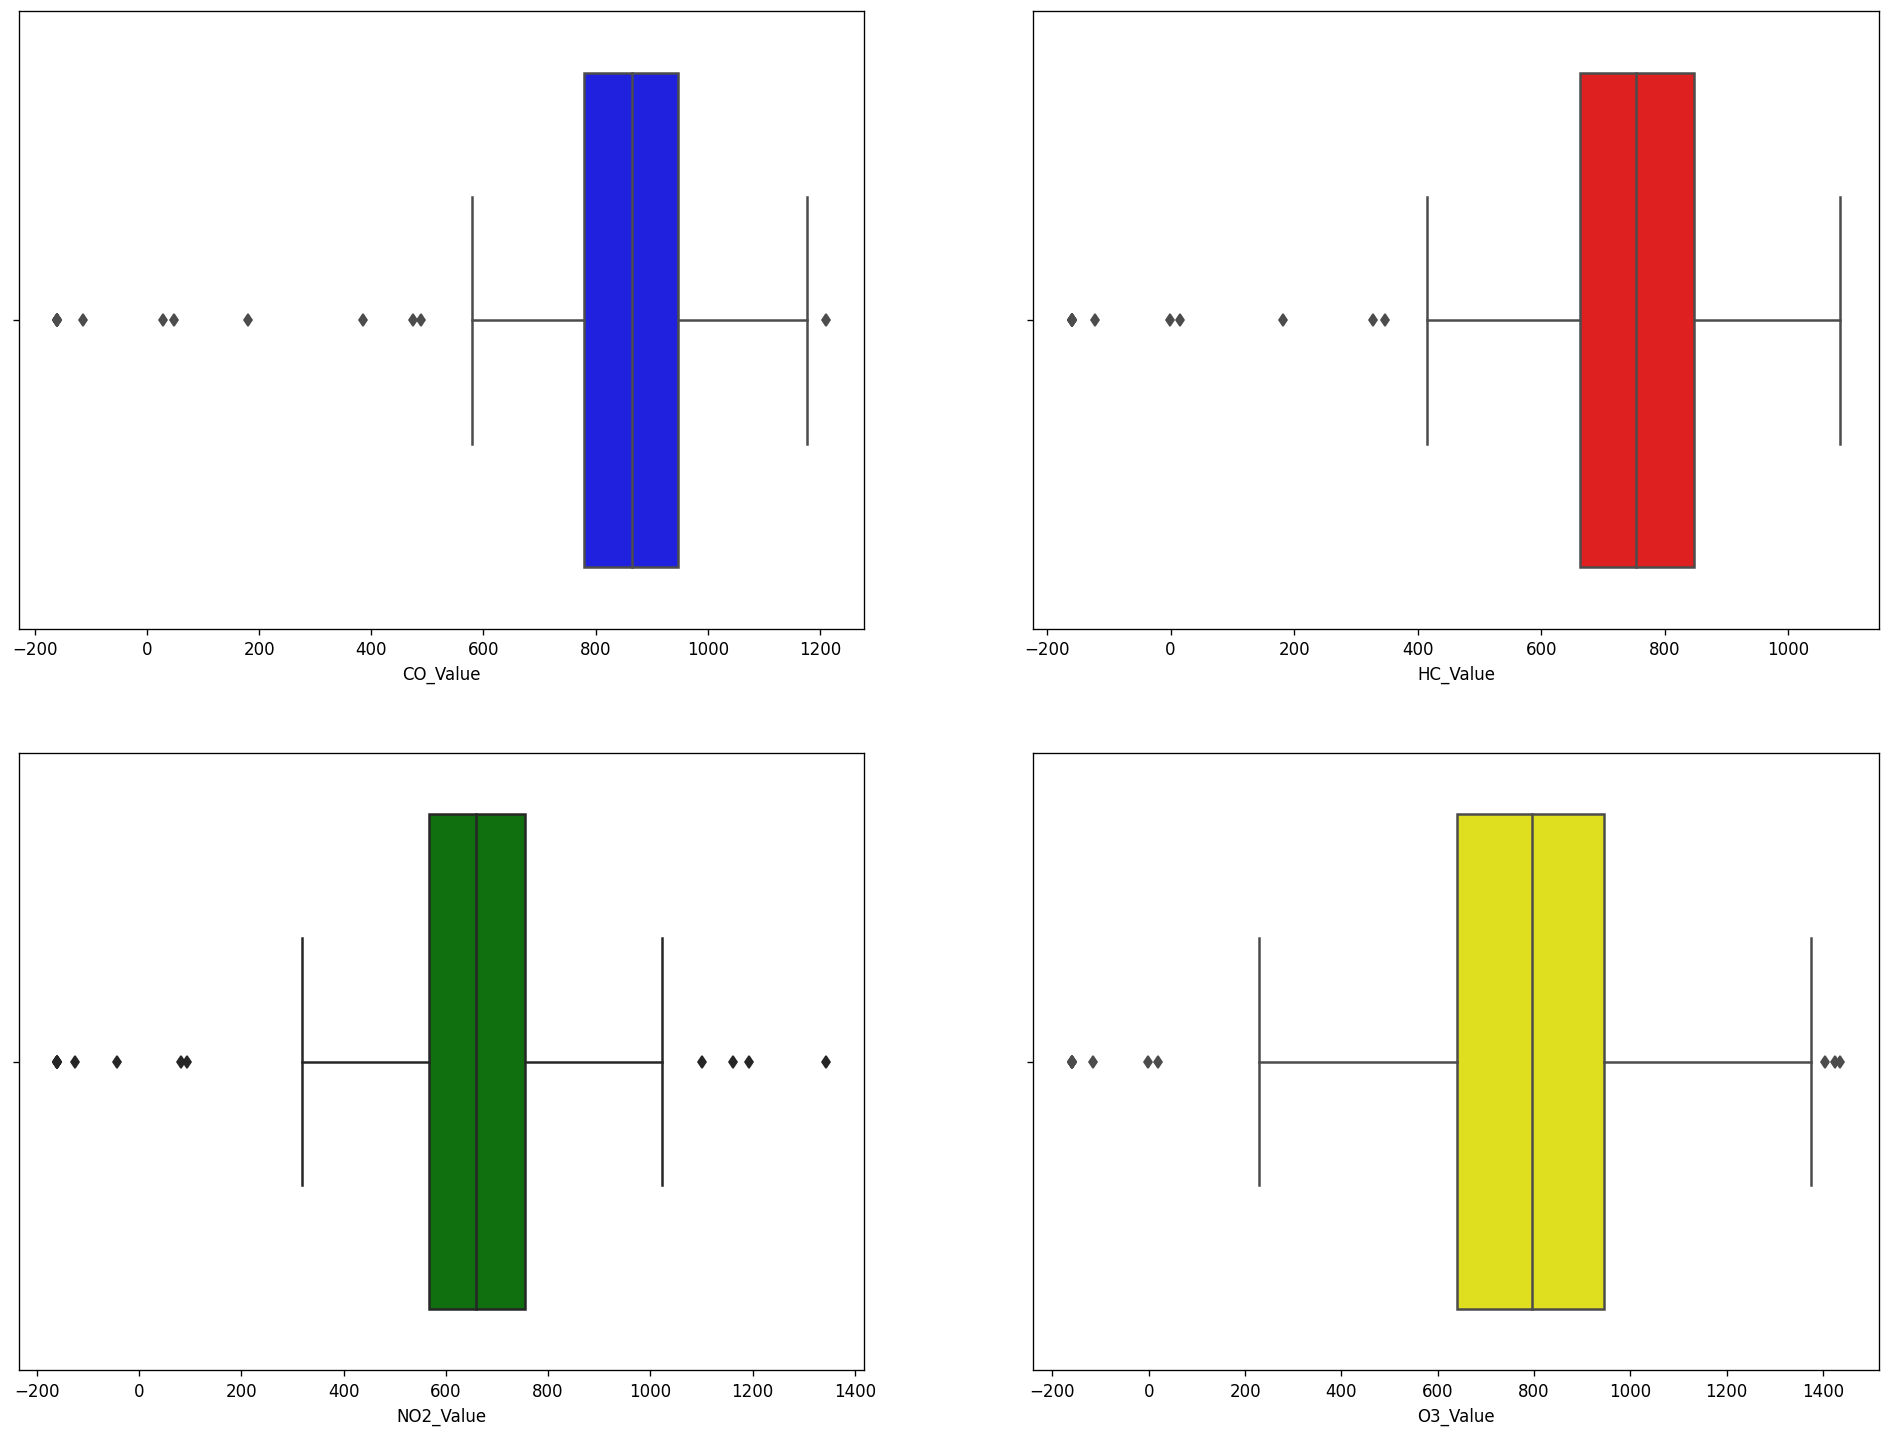

<Figure size 1920x600 with 0 Axes>

In [ ]:

fig,axes = plt.subplots(nrows=2,ncols=2)
plt.figure(figsize=(16,5))
sns.boxplot(analyse['CO_Value'],color='blue',ax=axes[0,0])
sns.boxplot(df['HC_Value'],color='red',ax=axes[0,1])
sns.boxplot(analyse['NO2_Value'],color='green',ax=axes[1,0])
sns.boxplot(analyse['O3_Value'],color='yellow',ax=axes[1,1])



### Perhaps bad results due to outlier 

In [ ]:
#2 std+mean of each gas value
hstd3co = analyse['CO_Value'].mean() + 2*analyse['CO_Value'].std()
hstd3hc = analyse['HC_Value'].mean() + 2*analyse['HC_Value'].std()
hstd3no2 = analyse['NO2_Value'].mean() + 2*analyse['NO2_Value'].std()
hstd3o3 = analyse['O3_Value'].mean() + 2*analyse['O3_Value'].std()
#2 std-mean of each gas value
lstd3co = analyse['CO_Value'].mean() - 2*analyse['CO_Value'].std()
lstd3hc = analyse['HC_Value'].mean() - 2*analyse['HC_Value'].std()
lstd3no2 = analyse['NO2_Value'].mean() - 2*analyse['NO2_Value'].std()
lstd3o3 = analyse['O3_Value'].mean() - 2*analyse['O3_Value'].std()

print(hstd3co,lstd3co)

1250.246527222645 430.92042739546486


317


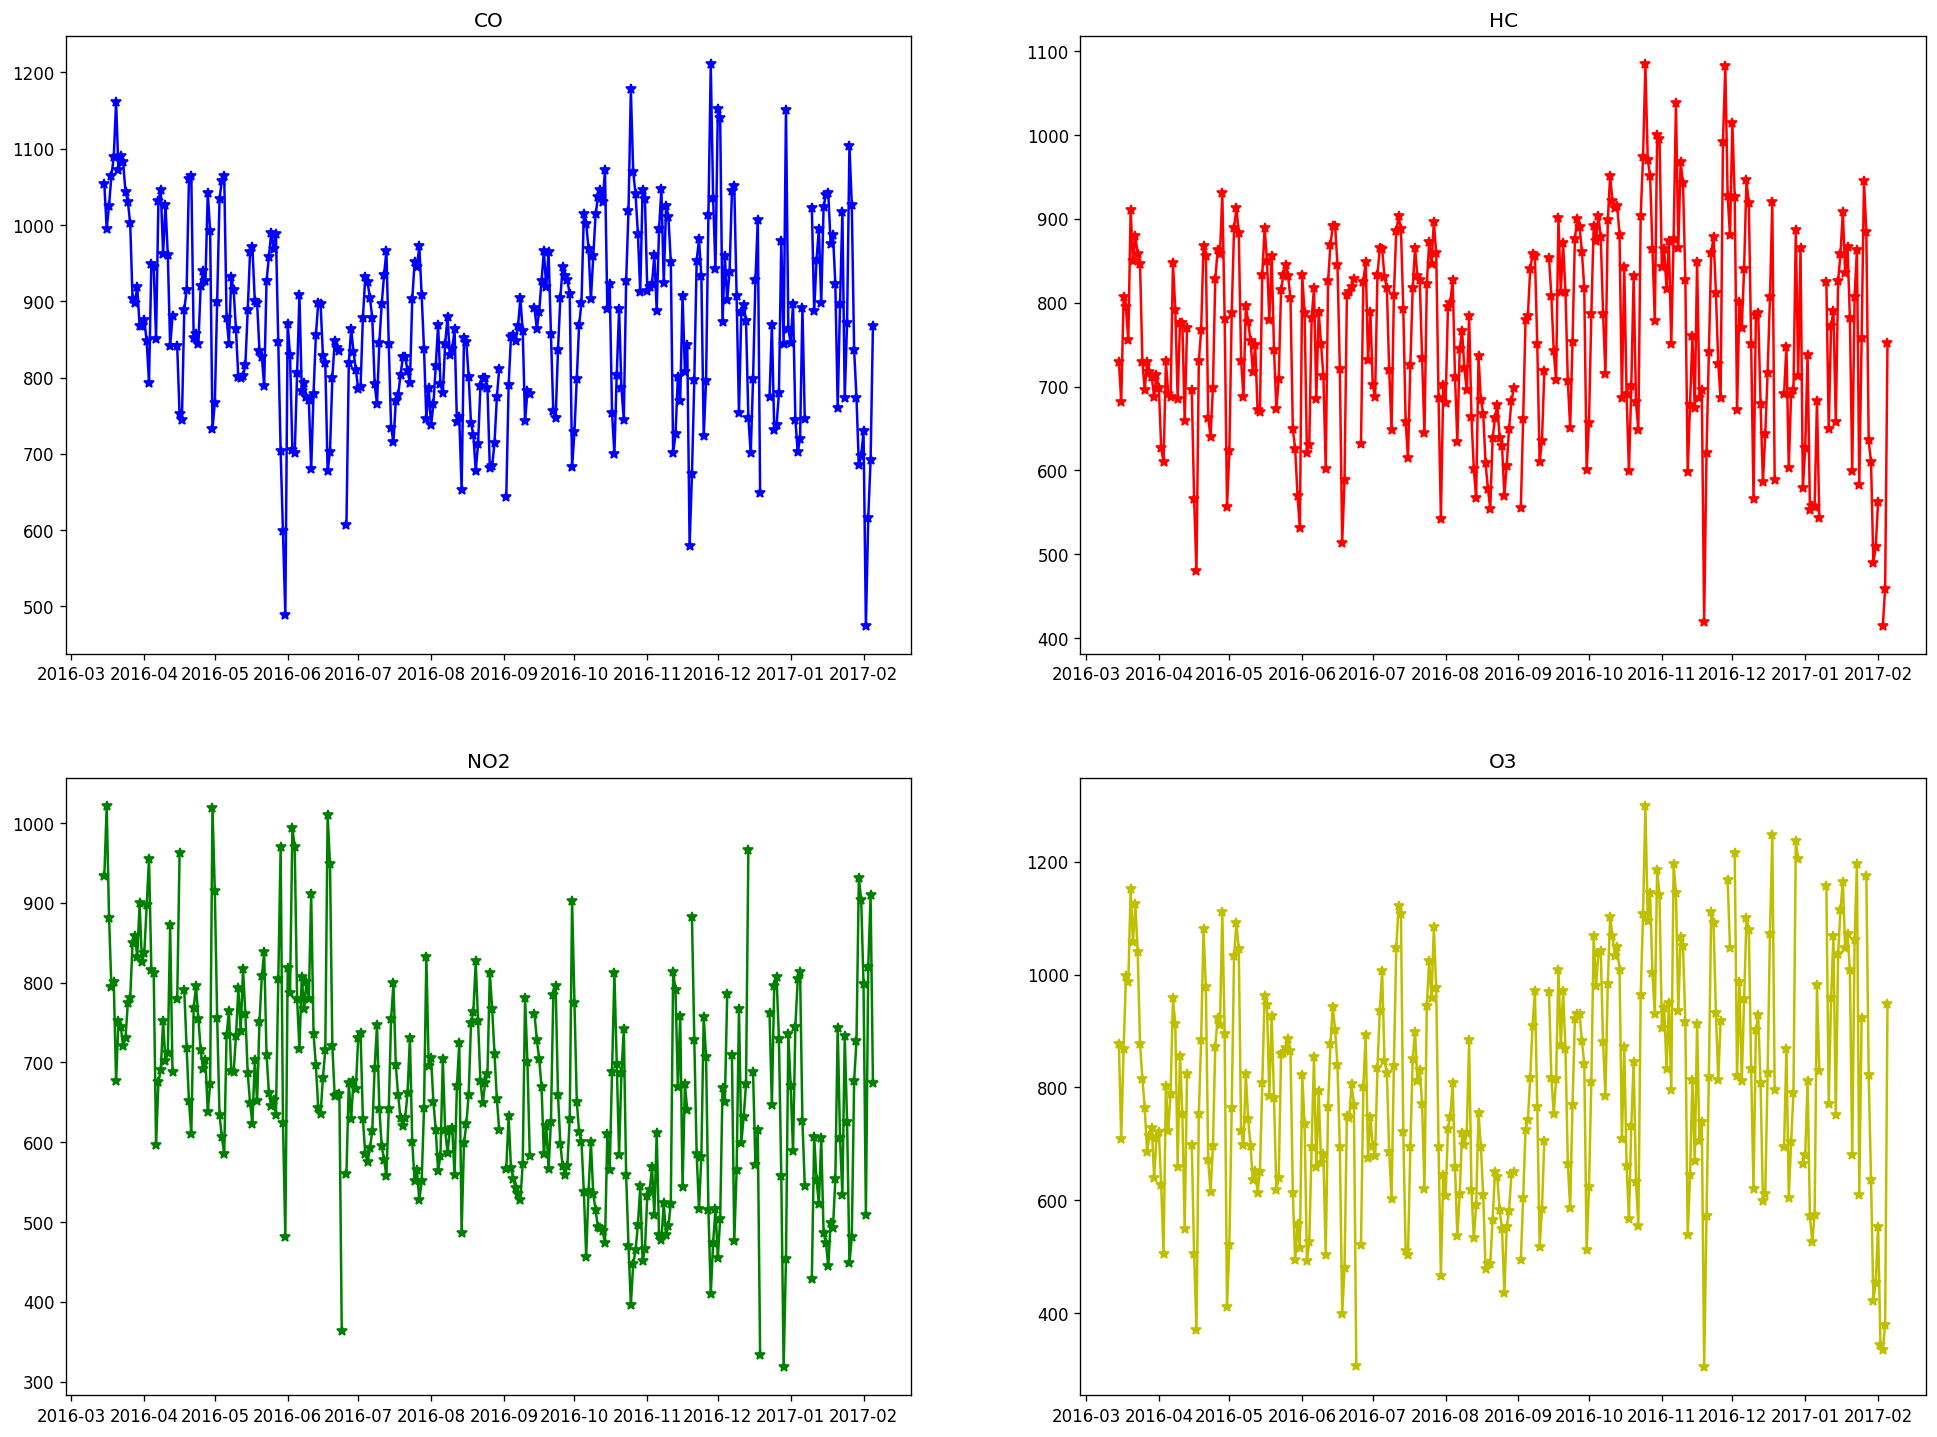

In [ ]:
#get all of CO_Values less than hstd3co and greater than lstd3co
analyse['CO_Value'] = analyse['CO_Value'][(analyse['CO_Value']<hstd3co) & (analyse['CO_Value']>lstd3co)]
#get all of HC_Values less than hstd3hc and greater than lstd3hc
analyse['HC_Value'] = analyse['HC_Value'][(analyse['HC_Value']<hstd3hc) & (analyse['HC_Value']>lstd3hc)]
#get all of NO2_Values less than hstd3no2 and greater than lstd3no2
analyse['NO2_Value'] = analyse['NO2_Value'][(analyse['NO2_Value']<hstd3no2) & (analyse['NO2_Value']>lstd3no2)]
#get all of O3_Values less than hstd3o3 and greater than lstd3o3
analyse['O3_Value'] = analyse['O3_Value'][(analyse['O3_Value']<hstd3o3) & (analyse['O3_Value']>lstd3o3)]

print(analyse.CO_Value.count())

analyse.CO_Value.resample('D')
analyse.HC_Value.resample('D')
analyse.NO2_Value.resample('D')
analyse.O3_Value.resample('D')




fig,axes = plt.subplots(nrows=2,ncols=2)
axes[0,0].plot(analyse.CO_Value,'b-*');axes[0,0].set_title('CO')
axes[0,1].plot(analyse.HC_Value,'r-*');axes[0,1].set_title('HC')
axes[1,0].plot(analyse.NO2_Value,'g-*');axes[1,0].set_title('NO2')
axes[1,1].plot(analyse.O3_Value,'y-*');axes[1,1].set_title('O3')

plt.show()



### Removing Outliers made gaps in the data

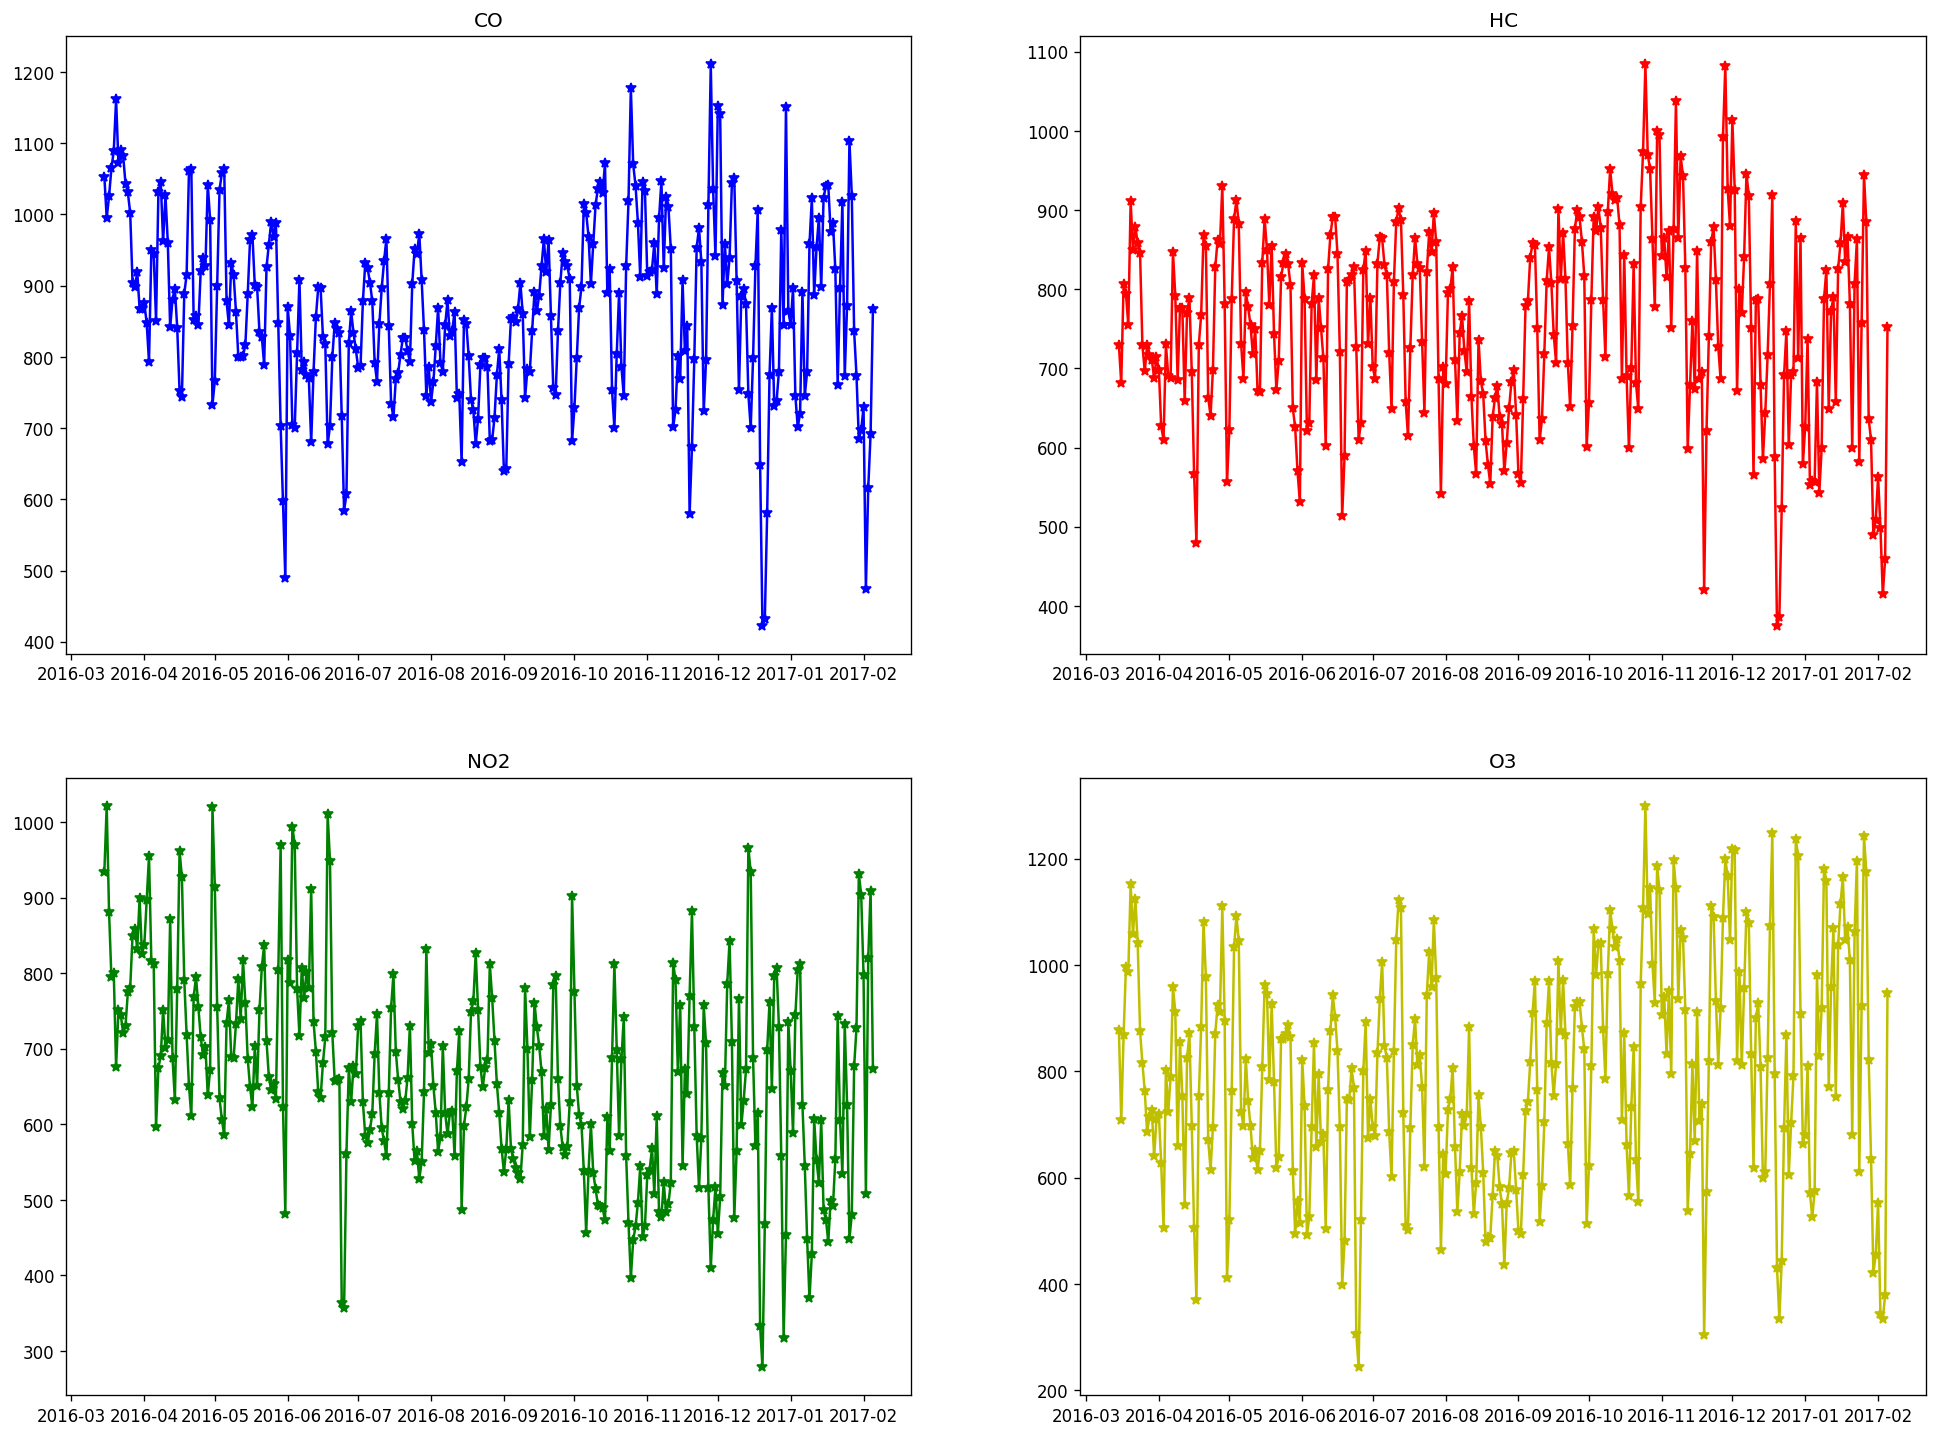

In [ ]:
analyse.CO_Value= analyse.CO_Value.interpolate(method='cubic')
analyse.HC_Value= analyse.HC_Value.interpolate(method='cubic')
analyse.NO2_Value= analyse.NO2_Value.interpolate(method='cubic')
analyse.O3_Value= analyse.O3_Value.interpolate(method='cubic')

fig,axes = plt.subplots(nrows=2,ncols=2)
axes[0,0].plot(analyse.CO_Value,'b-*');axes[0,0].set_title('CO')
axes[0,1].plot(analyse.HC_Value,'r-*');axes[0,1].set_title('HC')
axes[1,0].plot(analyse.NO2_Value,'g-*');axes[1,0].set_title('NO2')
axes[1,1].plot(analyse.O3_Value,'y-*');axes[1,1].set_title('O3')

plt.show()
